In [74]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import scipy.interpolate as sci_int
import os
import niche
from itertools import combinations
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from scipy.stats import variation
from scipy.spatial import distance
import math
import ATN

results_folder = 'paper_webs_0624'
WEBS = 37
metric_colors = ['pink','lightblue','lightgreen','lightcoral','lightgreen']
colors = ['tab:blue','tab:green','tab:orange','tab:purple']
symbols = ['^','v','o','X']
sizes = [75,75,80,75]
num_sims = [45,45,729] # per web in each category
mang_labels = ['intro intermediate', 'intro top', 'intro both','no intro']
label_strs = ["Intermediate Species Final Biomass","Top Species Final Biomass",\
              "% Change Ecosystem Service Amount", "Fraction Resident Species Remaining", \
             "Final Ecosystem Service Amount"]

In [75]:
# COLLECT METRICS FOR PLOTTING -- STANDARD RESULTS!

fif_webs_file = open('./' + results_folder + '/over15_webs.txt','r')
counter_file = open('./' + results_folder + '/counterfactual_results_newmet.csv','r')
counter_reader = csv.reader(counter_file)
next(counter_reader) # go past header

# Save the metrics across webs to plot
# intro 1, intro 2, es, bio, es raw
ct_mets = np.zeros((WEBS,5))
alt1_mets = np.zeros((WEBS,5,num_sims[0])) 
alt2_mets = np.zeros((WEBS,5,num_sims[1]))
alt3_mets = np.zeros((WEBS,5,num_sims[2]))

# map id used in code to id i wil use in write up (1-n)
web_map = {}
wi = 1

ct = 0 
for row in fif_webs_file:
    
    i = int(row)
    web_map[wi] = i
    wi+=1
    counter_res = next(counter_reader)
    assert int(counter_res[0]) == i, "web id doesn't match"

    print("web " + str(i))

    alt1_file = open('./' + results_folder + '/web_' + str(i) + '_invader_1_newmet.csv','r')
    alt1_reader = csv.reader(alt1_file)
    next(alt1_reader)
    alt2_file = open('./' + results_folder + '/web_' + str(i) + '_invader_2_newmet.csv','r')
    alt2_reader = csv.reader(alt2_file)
    next(alt2_reader)
    alt3_file = open('./' + results_folder + '/web_' + str(i) + '_invader_both_newmet.csv','r')
    alt3_reader = csv.reader(alt3_file)
    next(alt3_reader)

    ct_mets[ct][0] = float(counter_res[1])
    ct_mets[ct][1] = float(counter_res[2])
    ct_mets[ct][2] = float(counter_res[3])
    ct_mets[ct][3] = float(counter_res[4])
    ct_mets[ct][4] = float(counter_res[5])

    cc = 0
    for row2 in alt1_reader:
        alt1_mets[ct][0][cc] = float(row2[1])
        alt1_mets[ct][1][cc] = float(row2[2])
        alt1_mets[ct][2][cc] = float(row2[3])
        alt1_mets[ct][3][cc] = float(row2[4])
        alt1_mets[ct][4][cc] = float(row2[5])

        cc +=1

    cc = 0
    for row2 in alt2_reader:
        alt2_mets[ct][0][cc] = float(row2[1])
        alt2_mets[ct][1][cc] = float(row2[2])
        alt2_mets[ct][2][cc] = float(row2[3])
        alt2_mets[ct][3][cc] = float(row2[4])
        alt2_mets[ct][4][cc] = float(row2[5])

        cc +=1

    cc = 0
    for row2 in alt3_reader:
        alt3_mets[ct][0][cc] = float(row2[2])
        alt3_mets[ct][1][cc] = float(row2[3])
        alt3_mets[ct][2][cc] = float(row2[4])
        alt3_mets[ct][3][cc] = float(row2[5])
        alt3_mets[ct][4][cc] = float(row2[6])

        cc +=1

    alt1_file.close()
    alt2_file.close()
    alt3_file.close()

    ct +=1

fif_webs_file.close()
counter_file.close()

print(web_map)

web 0
web 4
web 8
web 10
web 13
web 14
web 16
web 18
web 19
web 24
web 25
web 28
web 34
web 35
web 36
web 39
web 40
web 41
web 43
web 47
web 48
web 49
web 50
web 55
web 57
web 59
web 65
web 66
web 69
web 70
web 74
web 75
web 76
web 77
web 87
web 93
web 99
{1: 0, 2: 4, 3: 8, 4: 10, 5: 13, 6: 14, 7: 16, 8: 18, 9: 19, 10: 24, 11: 25, 12: 28, 13: 34, 14: 35, 15: 36, 16: 39, 17: 40, 18: 41, 19: 43, 20: 47, 21: 48, 22: 49, 23: 50, 24: 55, 25: 57, 26: 59, 27: 65, 28: 66, 29: 69, 30: 70, 31: 74, 32: 75, 33: 76, 34: 77, 35: 87, 36: 93, 37: 99}


In [76]:
# PLOTTING HELPER FUNCTIONS

def cent_mean(x,y):
    return [np.mean(x),np.mean(y)]

def cent_med(x,y):
    med_x = np.median(x)
    med_y = np.median(y)
    return [med_x,med_y]

def plot_cent_hull(xs,ys,cc,ll,cols,axs):
    cent = cent_mean(xs,ys)
    max_y = np.max(ys)
    min_y = np.min(ys)
    max_x = np.max(xs)
    min_x = np.min(xs)

    #convex hull
    points = np.transpose(np.array([xs,ys]))
    try: 
        hull = ConvexHull(points)
        mxp = len(points[hull.vertices,0])-1
        mxx = np.append(points[hull.vertices,0],points[hull.vertices,0][0])
        myy = np.append(points[hull.vertices,1],points[hull.vertices,1][0])
        axs.plot(mxx,myy,color=cols[cc],linestyle='--')

    except:
        # "FLAT" case
        #vertical flat
        if min_y == max_y:
            axs.plot([min_x,max_x],[cent[1],cent[1]], color=cols[cc], linestyle='--')
        #horizontal flat
        if min_x == max_x:
            axs.plot([cent[0],cent[0]],[min_y,max_y], color=cols[cc], linestyle='--')
            
def get_medians(xx,yy):
    xs1 = []
    for i in range(0,WEBS):
        xs1.append(np.median(alt1_mets[i][xx][:]))
        
    xs2 = []
    for i in range(0,WEBS):
        xs2.append(np.median(alt2_mets[i][xx][:]))
    
    xs3 = []
    for i in range(0,WEBS):
        xs3.append(np.median(alt3_mets[i][xx][:]))
    
    xs4 = []
    for i in range(0,WEBS):
        xs4.append(ct_mets[i][xx])
        
    ys1 = []
    for i in range(0,WEBS):
        ys1.append(np.median(alt1_mets[i][yy][:]))
        
    ys2 = []
    for i in range(0,WEBS):
        ys2.append(np.median(alt2_mets[i][yy][:]))
    
    ys3 = []
    for i in range(0,WEBS):
        ys3.append(np.median(alt3_mets[i][yy][:]))
    
    ys4 = []
    for i in range(0,WEBS):
        ys4.append(ct_mets[i][yy])
        
    return xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4

def get_means(xx,yy):
    xs1 = []
    for i in range(0,WEBS):
        xs1.append(np.mean(alt1_mets[i][xx][:]))
        
    xs2 = []
    for i in range(0,WEBS):
        xs2.append(np.mean(alt2_mets[i][xx][:]))
    
    xs3 = []
    for i in range(0,WEBS):
        xs3.append(np.mean(alt3_mets[i][xx][:]))
    
    xs4 = []
    for i in range(0,WEBS):
        xs4.append(ct_mets[i][xx])
        
    ys1 = []
    for i in range(0,WEBS):
        ys1.append(np.mean(alt1_mets[i][yy][:]))
        
    ys2 = []
    for i in range(0,WEBS):
        ys2.append(np.mean(alt2_mets[i][yy][:]))
    
    ys3 = []
    for i in range(0,WEBS):
        ys3.append(np.mean(alt3_mets[i][yy][:]))
    
    ys4 = []
    for i in range(0,WEBS):
        ys4.append(ct_mets[i][yy])
        
    return xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4

def get_for_web(i,xx,yy):
    xs1 = alt1_mets[i][xx][:]
    xs2 = alt2_mets[i][xx][:]
    xs3 = alt3_mets[i][xx][:]
    xs4 = [ct_mets[i][xx]]
    ys1 = alt1_mets[i][yy][:]
    ys2 = alt2_mets[i][yy][:]
    ys3 = alt3_mets[i][yy][:]
    ys4 = [ct_mets[i][yy]]
    return xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4

# TO DO - double check these and make sure they return same, compare to existing libraries
def pareto_id(pts):
    # identify pareto-efficient vs. suboptimal options 
    # these are ones where you can't find another point that has more of one thing w/o less of other
    pareto = [0]*len(pts)
    for ii in range(0,len(pts)):
        sub = False
        xval = pts[ii][0]
        yval = pts[ii][1]
        for pp in pts:
            # yes I can improve in terms of x
            if pp[0] > xval:
                # does this improvement in x also come with improvement (or no change) in y?
                if pp[1] >= yval:
                    sub = True # if so, this point is suboptimal

            # yes I can improve in terms of y
            if pp[1] > yval:
                # does this improvement in y also come with improvement (or no change) in x?
                if pp[0] >= xval:
                    sub = True # if so, this point is suboptimal

        # if no improvments in x come with improvement in y
        if sub == False:
            pareto[ii] = 1
            
    return pareto

# get the closest outcome to the origin 
def worse_case_dist(origin,points):
    shortest_dist = 100000000000
    worse_case = None
    for i in range(0, len(points)):
        curr_pt = points[i]
        curr_dist = distance.euclidean(origin,curr_pt)
        if curr_dist < shortest_dist:
            shortest_dist = curr_dist
            worse_case = i
    return worse_case,shortest_dist

In [77]:
# PLOTTING ALL SIMULATION OUTPUTS FOR A SINGLE WEB! 
def draw_blobs_plot(web_index,xx,yy,cols,sims,ss,xlab,ylab,legend,titl,axs):
    
    xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_for_web(web_index,xx,yy)
    
    axs.scatter(xs3,ys3, color=cols[2], marker=sims[2], s=ss[2], alpha=0.3, label=mang_labels[2])
    axs.scatter(xs1,ys1, color=cols[0], marker=sims[0], s=ss[0], alpha=0.3, label=mang_labels[0])
    axs.scatter(xs2,ys2, color=cols[1], marker=sims[1], s=ss[1], alpha=0.3, label=mang_labels[1])

    plot_cent_hull(xs1,ys1,0,mang_labels[0],cols,axs)
    plot_cent_hull(xs2,ys2,1,mang_labels[1],cols,axs)
    plot_cent_hull(xs3,ys3,2,mang_labels[2],cols,axs)
    axs.scatter(xs4,ys4, c=cols[3], marker=sims[3],s=ss[3], label= mang_labels[3])

    if (legend):
        lg = axs.legend(title="Management strategies", loc="upper right")
        for lh in lg.legendHandles: 
            lh.set_alpha(1)
            
    if xlab:
        axs.set_xlabel(xlab,fontweight='bold')
    if ylab:
        axs.set_ylabel(ylab,fontweight='bold')
    
    xs1m, xs2m, xs3m, xs4m, ys1m, ys2m, ys3m, ys4m = get_medians(xx,yy)

    overall_xmin = np.min([np.min(xs1),np.min(xs2),np.min(xs3),np.min(xs4),np.min(xs1m),np.min(xs2m),np.min(xs3m),np.min(xs4m)])
    overall_xmax = np.max([np.max(xs1),np.max(xs2),np.max(xs3),np.max(xs4),np.max(xs1m),np.max(xs2m),np.max(xs3m),np.max(xs4m)])
    x_range = overall_xmax - overall_xmin

    overall_ymin = np.min([np.min(ys1),np.min(ys2),np.min(ys3),np.min(ys4),np.min(ys1m),np.min(ys2m),np.min(ys3m),np.min(ys4m)])
    overall_ymax = np.max([np.max(ys1),np.max(ys2),np.max(ys3),np.max(ys4),np.max(ys1m),np.max(ys2m),np.max(ys3m),np.max(ys4m)])
    y_range = overall_ymax - overall_ymin

    axs.set_xlim([overall_xmin-x_range*0.05,overall_xmax+x_range*0.05])
    axs.set_ylim([overall_ymin-y_range*0.05,overall_ymax+y_range*0.05])
    
    if titl:
        axs.set_title("All Simulation Outputs",fontweight='bold')

In [78]:
# DRAW PLOT WITH JUST THE SUMMARY (MEAN OR MEDIAN) + plausible efficiency frontier 
def draw_frontier_plot(web_index,xx,yy,cols,sims,ss,xlab,ylab,legend,titl,axs,use_medians):

    xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_for_web(web_index,xx,yy)
    
    pts = []
    
    if use_medians:
        cent1 = cent_med(xs1,ys1)
        pts.append(cent1)
        cent2 = cent_med(xs2,ys2)
        pts.append(cent2)
        cent3 = cent_med(xs3,ys3)
        pts.append(cent3)
        pts.append([xs4[0],ys4[0]])
    
    else:
        cent1 = cent_mean(xs1,ys1)
        pts.append(cent1)
        cent2 = cent_mean(xs2,ys2)
        pts.append(cent2)
        cent3 = cent_mean(xs3,ys3)
        pts.append(cent3)
        pts.append([xs4[0],ys4[0]])

    pareto = pareto_id(pts)
    
    #decorations for points
    subx = []
    suby = []
    alphas = []
    opt_cts = np.zeros((4))
    for pp in range(0,len(pareto)):
        if pareto[pp] == 0:
            subx.append(pts[pp][0])
            suby.append(pts[pp][1])
            alphas.append(0.3)
        else:
            alphas.append(1)
            opt_cts[pp] += 1
    
    xs1m, xs2m, xs3m, xs4m, ys1m, ys2m, ys3m, ys4m = get_medians(xx,yy)

    overall_xmin = np.min([np.min(xs1),np.min(xs2),np.min(xs3),np.min(xs4),np.min(xs1m),np.min(xs2m),np.min(xs3m),np.min(xs4m)])
    overall_xmax = np.max([np.max(xs1),np.max(xs2),np.max(xs3),np.max(xs4),np.max(xs1m),np.max(xs2m),np.max(xs3m),np.max(xs4m)])
    x_range = overall_xmax - overall_xmin

    overall_ymin = np.min([np.min(ys1),np.min(ys2),np.min(ys3),np.min(ys4),np.min(ys1m),np.min(ys2m),np.min(ys3m),np.min(ys4m)])
    overall_ymax = np.max([np.max(ys1),np.max(ys2),np.max(ys3),np.max(ys4),np.max(ys1m),np.max(ys2m),np.max(ys3m),np.max(ys4m)])
    y_range = overall_ymax - overall_ymin

    small_cap = x_range*0.01
    opt1 = axs.scatter(cent1[0],cent1[1],color=cols[0],marker=sims[0],s=ss[0])
    axs.plot([cent1[0],cent1[0]],[np.percentile(ys1,25),np.percentile(ys1,75)], color=cols[0])
    axs.plot([cent1[0]-small_cap,cent1[0]+small_cap],[np.percentile(ys1,25),np.percentile(ys1,25)], color=cols[0])
    axs.plot([cent1[0]-small_cap,cent1[0]+small_cap],[np.percentile(ys1,75),np.percentile(ys1,75)], color=cols[0])

    opt2 = axs.scatter(cent2[0],cent2[1],color=cols[1],marker=sims[1],s=ss[1])
    axs.plot([cent2[0],cent2[0]],[np.percentile(ys2,25),np.percentile(ys2,75)],color=cols[1])
    axs.plot([cent2[0]-small_cap,cent2[0]+small_cap],[np.percentile(ys2,25),np.percentile(ys2,25)],color=cols[1])
    axs.plot([cent2[0]-small_cap,cent2[0]+small_cap],[np.percentile(ys2,75),np.percentile(ys2,75)],color=cols[1])

    opt3 = axs.scatter(cent3[0],cent3[1],color=cols[2],marker=sims[2],s=ss[2])
    axs.plot([cent3[0],cent3[0]],[np.percentile(ys3,25),np.percentile(ys3,75)],color=cols[2])
    axs.plot([cent3[0]-small_cap,cent3[0]+small_cap],[np.percentile(ys3,25),np.percentile(ys3,25)],color=cols[2])
    axs.plot([cent3[0]-small_cap,cent3[0]+small_cap],[np.percentile(ys3,75),np.percentile(ys3,75)],color=cols[2])

    opt4 = axs.scatter(xs4,ys4, color=cols[3],marker=sims[3],s=ss[3])
    
    opt_hands = [opt1,opt2,opt3,opt4]
    
    # draw a "plausible" efficiency frontier
    ef = []
    s_hands = []
    o_hands = []
    for pp in range(0,len(pareto)):
        if pareto[pp] == 1:
            ef.append(pts[pp])
            o_hands.append(opt_hands[pp])
        else:
            s_hands.append(opt_hands[pp])

    #sort by x
    ef = sorted(ef)            
    efx = []
    efy = []
    for pp in range(0,len(ef)):
        efx.append(ef[pp][0])
        efy.append(ef[pp][1])

    # if there are three or more pareto optimal points
    one_pt = False
    if len(efx) == 4:

        #line 1
        xnew = np.linspace(overall_xmin-x_range*0.05, efx[1], num=50, endpoint=True)
        m = (efy[1]-efy[0])/(efx[1]-efx[0])
        b = -m*(efx[0]) + efy[0]
        ynew = m*xnew + b
        axs.plot(xnew,ynew,linestyle="--",color ='k')

        #line 2
        xnew = np.linspace(efx[1], efx[2], num=50, endpoint=True)
        m = (efy[2]-efy[1])/(efx[2]-efx[1])
        b = -m*(efx[1]) + efy[1]
        ynew = m*xnew + b
        axs.plot(xnew,ynew,linestyle="--",color ='k')

        #line 3
        xnew = np.linspace(efx[2], overall_xmax+x_range*0.05, num=50, endpoint=True)
        m = (efy[3]-efy[2])/(efx[3]-efx[2])
        b = -m*(efx[2]) + efy[2]
        ynew = m*xnew + b
        ef = axs.plot(xnew,ynew,linestyle="--",color ='k')

    elif len(efx) == 3:
        #line 1
        xnew = np.linspace(overall_xmin-x_range*0.05, efx[1], num=50, endpoint=True)
        m = (efy[1]-efy[0])/(efx[1]-efx[0])
        b = -m*(efx[0]) + efy[0]
        ynew = m*xnew + b
        axs.plot(xnew,ynew,linestyle="--",color ='k')

        #line 2
        xnew = np.linspace(efx[1], overall_xmax+x_range*0.05, num=50, endpoint=True)
        m = (efy[2]-efy[1])/(efx[2]-efx[1])
        b = -m*(efx[1]) + efy[1]
        ynew = m*xnew + b
        ef = axs.plot(xnew,ynew,linestyle="--",color ='k')

    # if there are two pareto optimal points
    elif len(efx) == 2:
        xnew = np.linspace(overall_xmin-x_range*0.05, overall_xmax+x_range*0.05, num=50, endpoint=True)
        m = (efy[1]-efy[0])/(efx[1]-efx[0])
        b = -m*(efx[0]) + efy[0]
        ynew = m*xnew + b
        ef = axs.plot(xnew,ynew,linestyle="--",color ='k') #, label=)

    # if there is only 1 pareto optimal point
    else:
        # don't connect 1 point
        one_pt = True
        xnew = np.linspace(overall_xmin-x_range*0.05, overall_xmax+x_range*0.05, num=50, endpoint=True)
        m = -1
        b = -m*(efx[0]) + efy[0]
        ynew = m*xnew + b
        #ef = axs.plot(xnew,ynew,linestyle="--",color ='k')
        ef = None

    if (legend):
        if ef and not one_pt:
            if len(s_hands) > 0:
                axs.legend([tuple(o_hands),tuple(s_hands),tuple(ef)], ['Pareto optimal strategies','Suboptimal strategies','Plausible efficiency frontier'], \
                           handler_map={tuple: HandlerTuple(ndivide=None,pad=1)})
            else:
                axs.legend([tuple(o_hands),tuple(ef)], ['Pareto optimal strategies','Plausible efficiency frontier'], \
                           handler_map={tuple: HandlerTuple(ndivide=None,pad=1)})
        else:
            axs.legend([tuple(o_hands),tuple(s_hands)], ['Pareto optimal stategies','Suboptimal strategies'], \
                       handler_map={tuple: HandlerTuple(ndivide=None,pad=1)})
            
    if xlab:
        axs.set_xlabel(xlab,fontweight='bold')
    if ylab:
        axs.set_ylabel(ylab,fontweight='bold')

    axs.set_xlim([overall_xmin-x_range*0.05,overall_xmax+x_range*0.05])
    axs.set_ylim([overall_ymin-y_range*0.05,overall_ymax+y_range*0.05])
    
    tstr = "Means"
    if use_medians:
        tstr = "Medians"
    if titl:
        axs.set_title(tstr + " and Interquartile Range",fontweight='bold')


In [79]:
# DRAW PLOT OF SUMMARY (MEAN OR MEDIAN) ACROSS WEBS
def draw_all_webs_plot(web_index,xx,yy,cols,sims,ss,xlab,ylab,legend,titl,axs,lower,summary_only,use_medians,small_plot):
    
    if use_medians:
        xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_medians(xx,yy)
    else:
        xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_means(xx,yy)
    
    subx = []
    suby = []
    opx = []
    opy = []
    curr_x = []
    curr_y = []
    opt_cts = np.zeros((4))
    for i in range(0,WEBS):
        #find suboptimal vs. optimal for each web
        pts = []
        pts.append([xs1[i],ys1[i]])
        pts.append([xs2[i],ys2[i]])
        pts.append([xs3[i],ys3[i]])
        pts.append([xs4[i],ys4[i]])
        
        if i == web_index:
            curr_x.append(xs1[i])
            curr_y.append(ys1[i])
            curr_x.append(xs2[i])
            curr_y.append(ys2[i])
            curr_x.append(xs3[i])
            curr_y.append(ys3[i])
            curr_x.append(xs4[i])
            curr_y.append(ys4[i])

        pareto = pareto_id(pts)
        for pp in range(0,len(pareto)):
            if pareto[pp] == 0:
                subx.append(pts[pp][0])
                suby.append(pts[pp][1])
            else:
                opt_cts[pp] += 1
                if i == web_index:
                    opx.append(pts[pp][0])
                    opy.append(pts[pp][1])

    axs.scatter(xs1,ys1, color=cols[0], marker=sims[0], s=ss[0], label=mang_labels[0])
    axs.scatter(xs2,ys2, color=cols[1], marker=sims[1], s=ss[1], label=mang_labels[1])
    axs.scatter(xs3,ys3, color=cols[2], marker=sims[2], s=ss[2], label=mang_labels[2])
    axs.scatter(xs4,ys4, c=cols[3], marker=sims[3],s=ss[3], label=mang_labels[3])
    if web_index != -1:
        axs.scatter(curr_x,curr_y,color='r',marker='o',facecolors='none',edgecolors='k',s=400)
        axs.scatter(opx,opy,color='r',marker='o',facecolors='none',edgecolors='k',linewidths=3,s=400)

    
    plot_cent_hull(xs1,ys1,0,mang_labels[0],cols,axs)
    plot_cent_hull(xs2,ys2,1,mang_labels[1],cols,axs)
    plot_cent_hull(xs3,ys3,2,mang_labels[2],cols,axs)
    
    # Small optimal counts bar plot
    if small_plot:
        if not lower:
            ins = axs.inset_axes([0.55,0.55,0.4,0.3])
        else:
            ins = axs.inset_axes([0.55,0.2,0.4,0.3])
        barx = np.arange(4)
        ins.bar(barx,opt_cts,color=cols)
        ins.set_xticks(barx)
        ins.set_xticklabels([])#mang_labels, rotation="vertical", fontweight='bold')


        xticklabels = ins.xaxis.get_ticklabels()
        for xticklabel in xticklabels:
            xticklabel.set_bbox(dict(facecolor='white', edgecolor='none'))

        ins.set_yticks([0,WEBS])
        ins.set_title("Pareto optimal strategies",fontweight='bold',bbox=dict(facecolor='white', edgecolor='none'))
        ins.set_ylim([0,WEBS])

    if (legend):
        axs.legend(bbox_to_anchor=(1,1), loc="upper left")
        
    if xlab:
        axs.set_xlabel(xlab,fontweight='bold')
    if ylab:
        axs.set_ylabel(ylab,fontweight='bold')

    xs1m, xs2m, xs3m, xs4m, ys1m, ys2m, ys3m, ys4m = get_for_web(web_index,xx,yy)
    
    #Base the plot x and y range only on summary metrics
    if summary_only:
        overall_xmin = np.min([np.min(xs1),np.min(xs2),np.min(xs3),np.min(xs4)])
        overall_xmax = np.max([np.max(xs1),np.max(xs2),np.max(xs3),np.max(xs4)])
        x_range = overall_xmax - overall_xmin

        overall_ymin = np.min([np.min(ys1),np.min(ys2),np.min(ys3),np.min(ys4)])
        overall_ymax = np.max([np.max(ys1),np.max(ys2),np.max(ys3),np.max(ys4)])
        y_range = overall_ymax - overall_ymin

    else:
        overall_xmin = np.min([np.min(xs1),np.min(xs2),np.min(xs3),np.min(xs4),np.min(xs1m),np.min(xs2m),np.min(xs3m),np.min(xs4m)])
        overall_xmax = np.max([np.max(xs1),np.max(xs2),np.max(xs3),np.max(xs4),np.max(xs1m),np.max(xs2m),np.max(xs3m),np.max(xs4m)])
        x_range = overall_xmax - overall_xmin

        overall_ymin = np.min([np.min(ys1),np.min(ys2),np.min(ys3),np.min(ys4),np.min(ys1m),np.min(ys2m),np.min(ys3m),np.min(ys4m)])
        overall_ymax = np.max([np.max(ys1),np.max(ys2),np.max(ys3),np.max(ys4),np.max(ys1m),np.max(ys2m),np.max(ys3m),np.max(ys4m)])
        y_range = overall_ymax - overall_ymin
    

    axs.set_xlim([overall_xmin-x_range*0.05,overall_xmax+x_range*0.05])
    axs.set_ylim([overall_ymin-y_range*0.05,overall_ymax+y_range*0.05])

    tstr = "Means"
    if use_medians:
        tstr = "Medians"
    if titl:
        axs.set_title(tstr + ", All Webs",fontweight='bold')

In [80]:
def draw_all_webs_bar_plot(xx,yy,cols,axs,use_medians):
        
    if use_medians:
        xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_medians(xx,yy)
    else:
        xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_means(xx,yy)
    
    opt_cts = np.zeros((4))
    for i in range(0,WEBS):
        #find suboptimal vs. optimal for each web
        pts = []
        pts.append([xs1[i],ys1[i]])
        pts.append([xs2[i],ys2[i]])
        pts.append([xs3[i],ys3[i]])
        pts.append([xs4[i],ys4[i]])
        pareto = pareto_id(pts)
        for pp in range(0,len(pareto)):
            if pareto[pp] == 1:
                opt_cts[pp] += 1

    barx = np.arange(4)
    axs.bar(barx,opt_cts,color=cols)
    axs.set_xticks(barx)
    axs.set_xticklabels(mang_labels, rotation=17)

#     xticklabels = axs.xaxis.get_ticklabels()
#     for xticklabel in xticklabels:
#         xticklabel.set_bbox(dict(facecolor='white', edgecolor='none'))

    axs.set_yticks([0,WEBS])
#     axs.set_title("Optimal strategies",fontweight='bold',bbox=dict(facecolor='white', edgecolor='none'))
    axs.set_title("Pareto optimal strategies",fontweight='bold')
    axs.set_ylabel("Count of networks")
    axs.set_ylim([0,WEBS])


In [81]:
# Draw the worst case summary plot for one web
def draw_worse_case_plot(web_index,xx,yy,cols,sims,ss,xlab,ylab,legend,titl,axs):

    xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_for_web(web_index,xx,yy)
    
    xs1m, xs2m, xs3m, xs4m, ys1m, ys2m, ys3m, ys4m = get_medians(xx,yy)

    overall_xmin = np.min([np.min(xs1),np.min(xs2),np.min(xs3),np.min(xs4),np.min(xs1m),np.min(xs2m),np.min(xs3m),np.min(xs4m)])
    overall_xmax = np.max([np.max(xs1),np.max(xs2),np.max(xs3),np.max(xs4),np.max(xs1m),np.max(xs2m),np.max(xs3m),np.max(xs4m)])
    x_range = overall_xmax - overall_xmin

    overall_ymin = np.min([np.min(ys1),np.min(ys2),np.min(ys3),np.min(ys4),np.min(ys1m),np.min(ys2m),np.min(ys3m),np.min(ys4m)])
    overall_ymax = np.max([np.max(ys1),np.max(ys2),np.max(ys3),np.max(ys4),np.max(ys1m),np.max(ys2m),np.max(ys3m),np.max(ys4m)])
    y_range = overall_ymax - overall_ymin
        
    # Scale x and y before getting distances to origin (min-max scaling, range [0,1])
    xs1_s = []
    ys1_s = []
    xs2_s = []
    ys2_s = []
    xs3_s = []
    ys3_s = []
    xs4_s = []
    ys4_s = []
    for ii in range(0,len(xs1)):
        xs1_s.append((xs1[ii]-overall_xmin)/(overall_xmax-overall_xmin))
        ys1_s.append((ys1[ii]-overall_ymin)/(overall_ymax-overall_ymin))
        xs2_s.append((xs2[ii]-overall_xmin)/(overall_xmax-overall_xmin))
        ys2_s.append((ys2[ii]-overall_ymin)/(overall_ymax-overall_ymin))
        xs3_s.append((xs3[ii]-overall_xmin)/(overall_xmax-overall_xmin))
        ys3_s.append((ys3[ii]-overall_ymin)/(overall_ymax-overall_ymin))

    xs4_s.append((xs4[0]-overall_xmin)/(overall_xmax-overall_xmin))
    ys4_s.append((ys4[0]-overall_ymin)/(overall_ymax-overall_ymin))
        
    origin = [0,0]
    
    points1_s = []
    points2_s = []
    points3_s = []
    points4_s = []
    for i in range(0,len(xs1_s)):
        points1_s.append((xs1_s[i],ys1_s[i]))
        points2_s.append((xs2_s[i],ys2_s[i]))
        points3_s.append((xs3_s[i],ys3_s[i]))
    points4_s.append((xs4_s[0],ys4_s[0]))
    
    #Find best worst case option
    worse_cases = np.zeros(4)
    #worst for management options
    wc1i,worse_cases[0] = worse_case_dist(origin,points1_s)
    wc2i,worse_cases[1] = worse_case_dist(origin,points2_s)
    wc3i,worse_cases[2] = worse_case_dist(origin,points3_s)
    _,worse_cases[3] = worse_case_dist(origin,points4_s)

    mini_max_decs = []
    max_val = np.max(worse_cases)
    for ii in range(0,len(worse_cases)):
        if worse_cases[ii] == max_val:
            mini_max_decs.append(ii)

    opt1 = axs.scatter(xs1[wc1i],ys1[wc1i],color=cols[0],marker=sims[0],s=ss[0])
    opt2 = axs.scatter(xs2[wc2i],ys2[wc2i],color=cols[1],marker=sims[1],s=ss[1])
    opt3 = axs.scatter(xs3[wc3i],ys3[wc3i],color=cols[2],marker=sims[2],s=ss[2])
    opt4 = axs.scatter(xs4,ys4, color=cols[3],marker=sims[3],s=ss[3])
    
    mm_hands = []
    opt_hands = [opt1,opt2,opt3,opt4]
    for ii in range(0,len(opt_hands)):
        if ii in mini_max_decs:
            mm_hands.append(opt_hands[ii])
            

    if (legend):
        axs.legend([tuple(mm_hands)], ['Maxi-min decisions'], handler_map={tuple: HandlerTuple(ndivide=None,pad=1)})
        
    axs.set_xlabel(xlab,fontweight='bold')
    axs.set_ylabel(ylab,fontweight='bold')

    axs.set_xlim([overall_xmin-x_range*0.05,overall_xmax+x_range*0.05])
    axs.set_ylim([overall_ymin-y_range*0.05,overall_ymax+y_range*0.05])
    
    if titl:
        axs.set_title("Worst Outcomes",fontweight='bold')


In [82]:
# Draw the worst case plot summarizing across all webs 
def draw_all_worst_plot(web_index,xx,yy,cols,sims,ss,xlab,ylab,legend,titl,axs,lower,zoomed,small_plot):
        
    xs1m, xs2m, xs3m, xs4m, ys1m, ys2m, ys3m, ys4m = get_medians(xx,yy)
    xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_for_web(web_index,xx,yy)

    overall_xmin = np.min([np.min(xs1),np.min(xs2),np.min(xs3),np.min(xs4),np.min(xs1m),np.min(xs2m),np.min(xs3m),np.min(xs4m)])
    overall_xmax = np.max([np.max(xs1),np.max(xs2),np.max(xs3),np.max(xs4),np.max(xs1m),np.max(xs2m),np.max(xs3m),np.max(xs4m)])
    x_range = overall_xmax - overall_xmin

    overall_ymin = np.min([np.min(ys1),np.min(ys2),np.min(ys3),np.min(ys4),np.min(ys1m),np.min(ys2m),np.min(ys3m),np.min(ys4m)])
    overall_ymax = np.max([np.max(ys1),np.max(ys2),np.max(ys3),np.max(ys4),np.max(ys1m),np.max(ys2m),np.max(ys3m),np.max(ys4m)])
    y_range = overall_ymax - overall_ymin
    
    x1w = []
    y1w = []
    x2w = []
    y2w = []
    x3w = []
    y3w = []
    x4w = []
    y4w = []
    
    opt_cts = [0,0,0,0]
    origin  = [0,0]
    opx = []
    opy = []
    curr_x = []
    curr_y = []
    
    for web_ind in range(0,WEBS):
        xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_for_web(web_ind,xx,yy)

        # Scale x and y before getting distances to origin (min-max scaling, range [0,1])
        xs1_s = []
        ys1_s = []
        xs2_s = []
        ys2_s = []
        xs3_s = []
        ys3_s = []
        xs4_s = []
        ys4_s = []
        for ii in range(0,len(xs1)):
            xs1_s.append((xs1[ii]-overall_xmin)/(overall_xmax-overall_xmin))
            ys1_s.append((ys1[ii]-overall_ymin)/(overall_ymax-overall_ymin))
            xs2_s.append((xs2[ii]-overall_xmin)/(overall_xmax-overall_xmin))
            ys2_s.append((ys2[ii]-overall_ymin)/(overall_ymax-overall_ymin))
            xs3_s.append((xs3[ii]-overall_xmin)/(overall_xmax-overall_xmin))
            ys3_s.append((ys3[ii]-overall_ymin)/(overall_ymax-overall_ymin))

        xs4_s.append((xs4[0]-overall_xmin)/(overall_xmax-overall_xmin))
        ys4_s.append((ys4[0]-overall_ymin)/(overall_ymax-overall_ymin))
        
        points1_s = []
        points2_s = []
        points3_s = []
        points4_s = []
        for i in range(0,len(xs1_s)):
            points1_s.append((xs1_s[i],ys1_s[i]))
            points2_s.append((xs2_s[i],ys2_s[i]))
            points3_s.append((xs3_s[i],ys3_s[i]))
        points4_s.append((xs4_s[0],ys4_s[0]))

        #Find best worst case option
        worse_cases = np.zeros(4)
        #worst for management options
        wc1i,worse_cases[0] = worse_case_dist(origin,points1_s)
        wc2i,worse_cases[1] = worse_case_dist(origin,points2_s)
        wc3i,worse_cases[2] = worse_case_dist(origin,points3_s)
        _,worse_cases[3] = worse_case_dist(origin,points4_s)

        max_val = np.max(worse_cases)
        for ii in range(0,len(worse_cases)):
            if worse_cases[ii] == max_val:
                opt_cts[ii] = opt_cts[ii] + 1 
                if web_ind == web_index:
                    if ii == 0:
                        opx.append(xs1[wc1i])
                        opy.append(ys1[wc1i])
                    elif ii == 1:
                        opx.append(xs2[wc2i])
                        opy.append(ys2[wc2i])
                    elif ii == 2:
                        opx.append(xs3[wc3i])
                        opy.append(ys3[wc3i])
                    else: 
                        opx.append(xs4[0])
                        opy.append(ys4[0])
                        
        if web_ind == web_index:
            curr_x.append(xs1[wc1i])
            curr_y.append(ys1[wc1i])
            curr_x.append(xs2[wc2i])
            curr_y.append(ys2[wc2i])
            curr_x.append(xs3[wc3i])
            curr_y.append(ys3[wc3i])
            curr_x.append(xs4[0])
            curr_y.append(ys4[0])
    
        x1w.append(xs1[wc1i])
        y1w.append(ys1[wc1i])
        x2w.append(xs2[wc2i])
        y2w.append(ys2[wc2i])
        x3w.append(xs3[wc3i])
        y3w.append(ys3[wc3i])
        x4w.append(xs4[0])
        y4w.append(ys4[0])

    axs.scatter(x1w,y1w, color=cols[0], marker=sims[0], s=ss[0], label=mang_labels[0])
    axs.scatter(x2w,y2w, color=cols[1], marker=sims[1], s=ss[1], label=mang_labels[1])
    axs.scatter(x3w,y3w, color=cols[2], marker=sims[2], s=ss[2], label=mang_labels[2])
    axs.scatter(x4w,y4w, c=cols[3], marker=sims[3],s=ss[3], label=mang_labels[3])
    if web_index != -1:
        axs.scatter(curr_x,curr_y, color='r', marker='o',facecolors='none', edgecolors='k',s=400)
        axs.scatter(opx,opy,color='r',marker='o',facecolors='none',linewidths=3,edgecolors='k',s=400)
    
    plot_cent_hull(x1w,y1w,0,mang_labels[0],cols,axs)
    plot_cent_hull(x2w,y2w,1,mang_labels[1],cols,axs)
    plot_cent_hull(x3w,y3w,2,mang_labels[2],cols,axs)
    
    # Small optimal counts bar plot
    if small_plot:
        if not lower:
            ins = axs.inset_axes([0.55,0.55,0.4,0.3])
        else:
            ins = axs.inset_axes([0.55,0.2,0.4,0.3])
        barx = np.arange(4)
        ins.bar(barx,opt_cts,color=cols)
        ins.set_xticks(barx)
        ins.set_xticklabels(mang_labels, rotation="vertical",fontweight='bold')
        ins.set_yticks([0,WEBS])
        ins.set_title("Maxi-min decisions",fontweight='bold')
        ins.set_ylim([0,WEBS])
        xticklabels = ins.xaxis.get_ticklabels()
        for xticklabel in xticklabels:
            xticklabel.set_bbox(dict(facecolor='white', edgecolor='none'))

    if (legend):
        axs.legend(bbox_to_anchor=(1,1), loc="upper left")
    axs.set_xlabel(xlab,fontweight='bold')
    axs.set_ylabel(ylab,fontweight='bold')
    
    # reset display axes based on scattered pts
    if zoomed:
        overall_xmin = np.min([np.min(x1w),np.min(x2w),np.min(x3w),np.min(x4w)])
        overall_xmax = np.max([np.max(x1w),np.max(x2w),np.max(x3w),np.max(x4w)])
        x_range = overall_xmax - overall_xmin

        overall_ymin = np.min([np.min(y1w),np.min(y2w),np.min(y3w),np.min(y4w)])
        overall_ymax = np.max([np.max(y1w),np.max(y2w),np.max(y3w),np.max(y4w)])
        y_range = overall_ymax - overall_ymin

    axs.set_xlim([overall_xmin-x_range*0.05,overall_xmax+x_range*0.05])
    axs.set_ylim([overall_ymin-y_range*0.05,overall_ymax+y_range*0.05])

    if titl:
        axs.set_title("Worst Outcomes, All Webs",fontweight='bold')

In [83]:
# Draw the worst case plot summarizing across all webs 
def draw_all_worst_bar_plot(web_index,xx,yy,cols,sims,ss,xlab,ylab,legend,titl,axs,lower,zoomed,small_plot):
        
    xs1m, xs2m, xs3m, xs4m, ys1m, ys2m, ys3m, ys4m = get_medians(xx,yy)
    xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_for_web(web_index,xx,yy)

    overall_xmin = np.min([np.min(xs1),np.min(xs2),np.min(xs3),np.min(xs4),np.min(xs1m),np.min(xs2m),np.min(xs3m),np.min(xs4m)])
    overall_xmax = np.max([np.max(xs1),np.max(xs2),np.max(xs3),np.max(xs4),np.max(xs1m),np.max(xs2m),np.max(xs3m),np.max(xs4m)])
    x_range = overall_xmax - overall_xmin

    overall_ymin = np.min([np.min(ys1),np.min(ys2),np.min(ys3),np.min(ys4),np.min(ys1m),np.min(ys2m),np.min(ys3m),np.min(ys4m)])
    overall_ymax = np.max([np.max(ys1),np.max(ys2),np.max(ys3),np.max(ys4),np.max(ys1m),np.max(ys2m),np.max(ys3m),np.max(ys4m)])
    y_range = overall_ymax - overall_ymin
    
    x1w = []
    y1w = []
    x2w = []
    y2w = []
    x3w = []
    y3w = []
    x4w = []
    y4w = []
    
    opt_cts = [0,0,0,0]
    origin  = [0,0]
    opx = []
    opy = []
    curr_x = []
    curr_y = []
    
    for web_ind in range(0,WEBS):
        xs1, xs2, xs3, xs4, ys1, ys2, ys3, ys4 = get_for_web(web_ind,xx,yy)

        # Scale x and y before getting distances to origin (min-max scaling, range [0,1])
        xs1_s = []
        ys1_s = []
        xs2_s = []
        ys2_s = []
        xs3_s = []
        ys3_s = []
        xs4_s = []
        ys4_s = []
        for ii in range(0,len(xs1)):
            xs1_s.append((xs1[ii]-overall_xmin)/(overall_xmax-overall_xmin))
            ys1_s.append((ys1[ii]-overall_ymin)/(overall_ymax-overall_ymin))
            xs2_s.append((xs2[ii]-overall_xmin)/(overall_xmax-overall_xmin))
            ys2_s.append((ys2[ii]-overall_ymin)/(overall_ymax-overall_ymin))
            xs3_s.append((xs3[ii]-overall_xmin)/(overall_xmax-overall_xmin))
            ys3_s.append((ys3[ii]-overall_ymin)/(overall_ymax-overall_ymin))

        xs4_s.append((xs4[0]-overall_xmin)/(overall_xmax-overall_xmin))
        ys4_s.append((ys4[0]-overall_ymin)/(overall_ymax-overall_ymin))
        
        points1_s = []
        points2_s = []
        points3_s = []
        points4_s = []
        for i in range(0,len(xs1_s)):
            points1_s.append((xs1_s[i],ys1_s[i]))
            points2_s.append((xs2_s[i],ys2_s[i]))
            points3_s.append((xs3_s[i],ys3_s[i]))
        points4_s.append((xs4_s[0],ys4_s[0]))

        #Find best worst case option
        worse_cases = np.zeros(4)
        #worst for management options
        wc1i,worse_cases[0] = worse_case_dist(origin,points1_s)
        wc2i,worse_cases[1] = worse_case_dist(origin,points2_s)
        wc3i,worse_cases[2] = worse_case_dist(origin,points3_s)
        _,worse_cases[3] = worse_case_dist(origin,points4_s)

        max_val = np.max(worse_cases)
        for ii in range(0,len(worse_cases)):
            if worse_cases[ii] == max_val:
                opt_cts[ii] = opt_cts[ii] + 1 
                if web_ind == web_index:
                    if ii == 0:
                        opx.append(xs1[wc1i])
                        opy.append(ys1[wc1i])
                    elif ii == 1:
                        opx.append(xs2[wc2i])
                        opy.append(ys2[wc2i])
                    elif ii == 2:
                        opx.append(xs3[wc3i])
                        opy.append(ys3[wc3i])
                    else: 
                        opx.append(xs4[0])
                        opy.append(ys4[0])
                        
        if web_ind == web_index:
            curr_x.append(xs1[wc1i])
            curr_y.append(ys1[wc1i])
            curr_x.append(xs2[wc2i])
            curr_y.append(ys2[wc2i])
            curr_x.append(xs3[wc3i])
            curr_y.append(ys3[wc3i])
            curr_x.append(xs4[0])
            curr_y.append(ys4[0])
    
        x1w.append(xs1[wc1i])
        y1w.append(ys1[wc1i])
        x2w.append(xs2[wc2i])
        y2w.append(ys2[wc2i])
        x3w.append(xs3[wc3i])
        y3w.append(ys3[wc3i])
        x4w.append(xs4[0])
        y4w.append(ys4[0])


    barx = np.arange(4)
    axs.bar(barx,opt_cts,color=cols)
    axs.set_xticks(barx)
    axs.set_xticklabels(mang_labels, rotation=17)
    axs.set_yticks([0,WEBS])
    axs.set_ylabel("Count of networks")
    axs.set_title("Maxi-min decisions",fontweight='bold')
    axs.set_ylim([0,WEBS])
    

In [84]:
# PLOTTING CODE 

def trade_off_plotting_code(rows_to_plot,i_to_show,medians,draw_all,file_name):

    fif_webs_file = open('./' + results_folder + '/over15_webs.txt','r')
    lowerz = [5]
    ct = 0
    for row in fif_webs_file:

        i = int(row)

        if i == i_to_show:

            combo_it = combinations(range(0,4),2)
            index_combos = []
            for c in combo_it:
                index_combos.append(c)
            fig, axes = plt.subplots(len(rows_to_plot), 3, figsize=(12,20/6*len(rows_to_plot)))
            oc = 0
            show_title = True
            show_legend = True
            
            rowc = 0
            for combo in index_combos:

                if rowc in rows_to_plot:

                    draw_blobs_plot(ct,combo[0],combo[1],colors,symbols,sizes,label_strs[combo[0]],label_strs[combo[1]],show_legend,show_title,axes.flat[oc])
                    oc +=1
                    
                    draw_frontier_plot(ct,combo[0],combo[1],colors,symbols,sizes,label_strs[combo[0]],label_strs[combo[1]],True,show_title,axes.flat[oc],medians)
                    oc +=1

                    if rowc in lowerz:
                        to_l = True
                    else:
                        to_l = False
                        
                    if draw_all:
                        draw_all_webs_plot(ct,combo[0],combo[1],colors,symbols,sizes,label_strs[combo[0]],label_strs[combo[1]],False,show_title,axes.flat[oc],to_l,False,medians,True)

                    oc +=1
                    show_title = False
                    show_legend = False

                rowc += 1

            fig.tight_layout()

            if file_name:

                plt.savefig('./paper_plots/' + file_name + '.png',dpi=600)
                plt.show()
                plt.close()
            
            else:
                plt.show()


        ct += 1

    fif_webs_file.close()

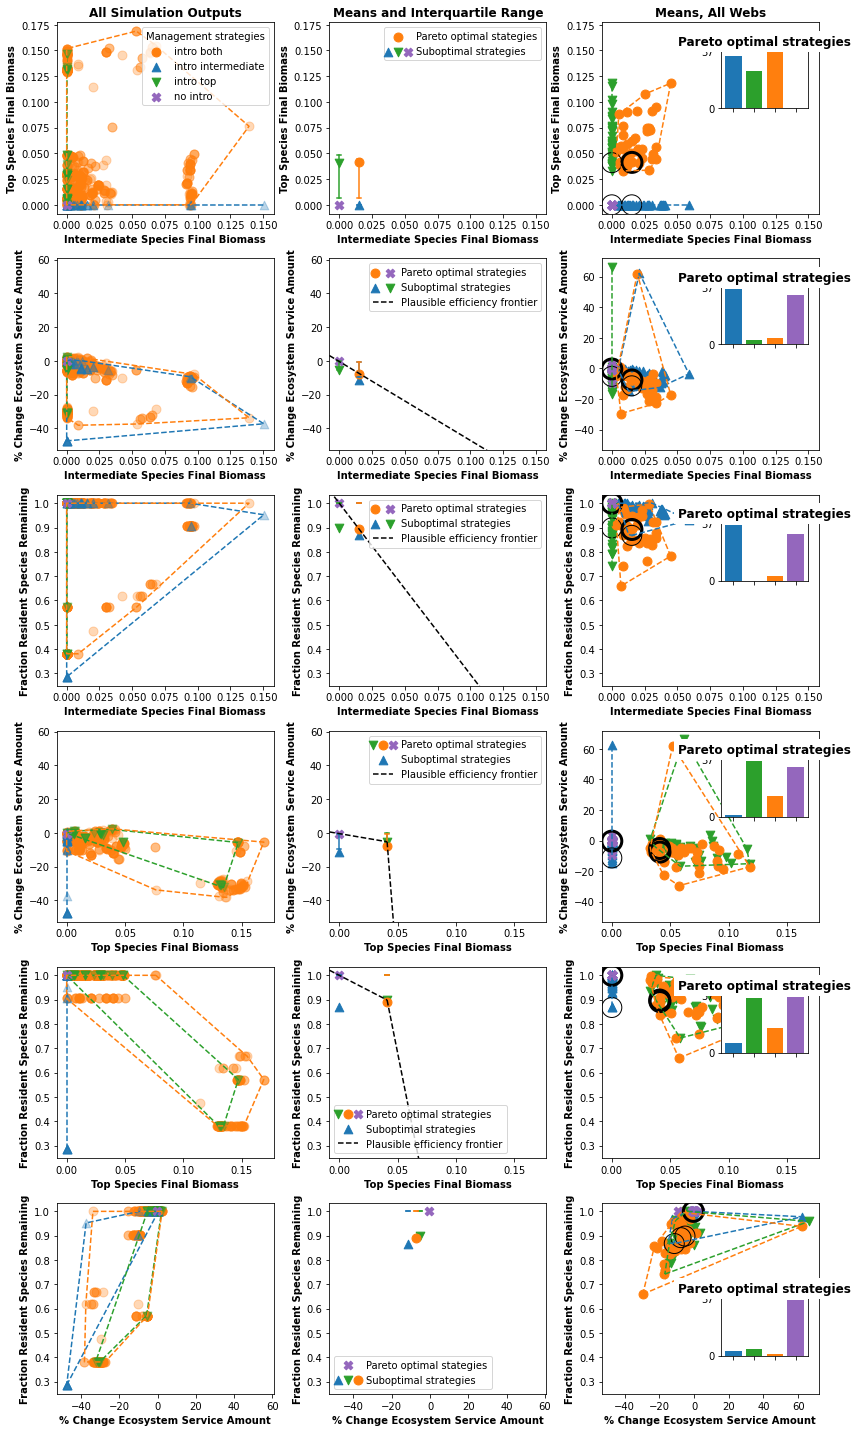

In [85]:
# Trade-off plots, full, means - SI Figure 5
rows_to_plot = range(0,6)
medians = False
i_to_show = 0
trade_off_plotting_code(rows_to_plot,i_to_show, medians,True,"SI_Fig_5")

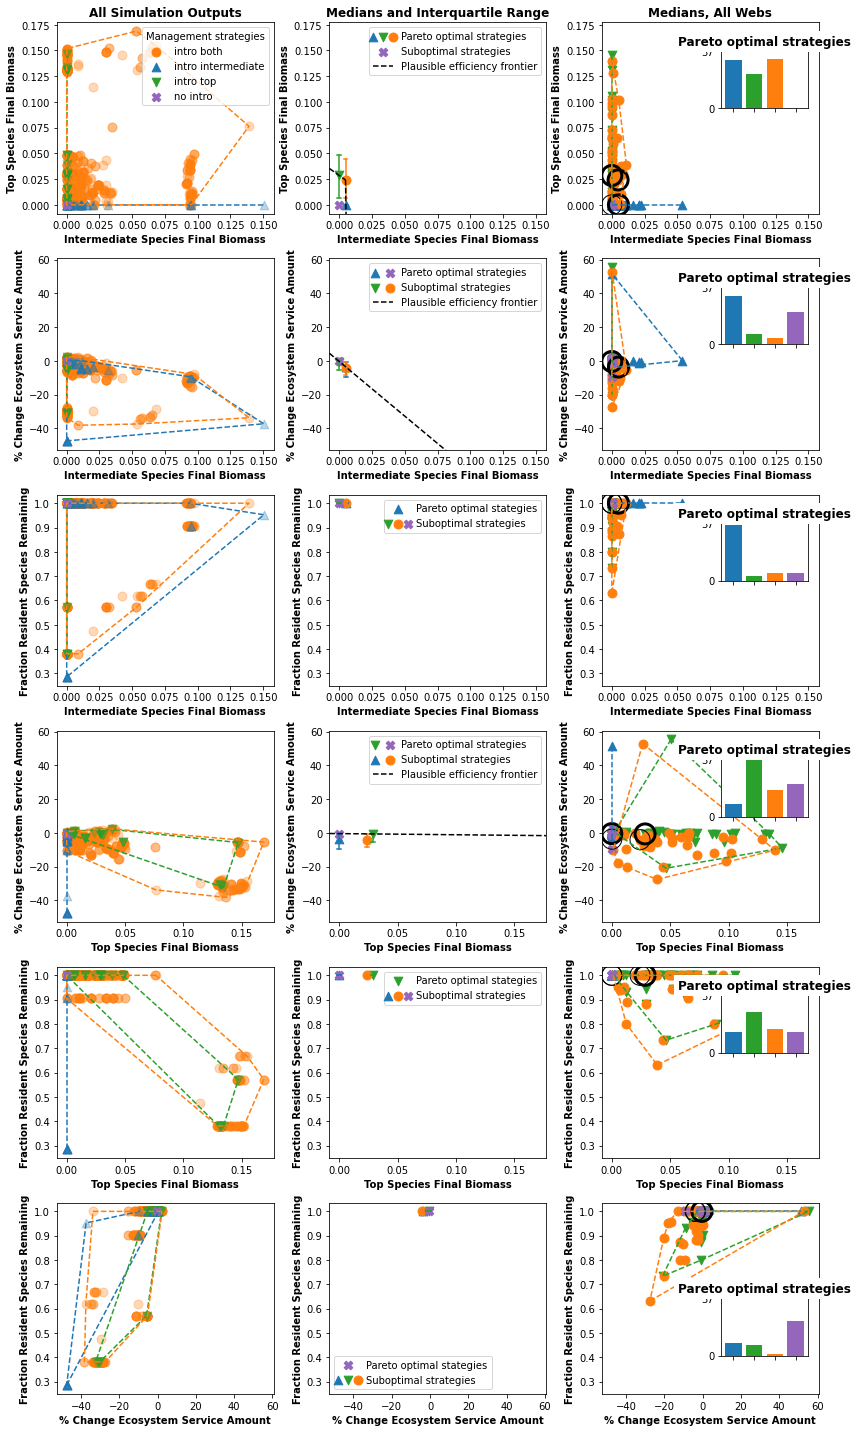

In [86]:
# Trade-off plots, full, medians - SI Figure 6
rows_to_plot = range(0,6)
medians = True
i_to_show = 0
trade_off_plotting_code(rows_to_plot,i_to_show,medians,True,"SI_Fig_6")

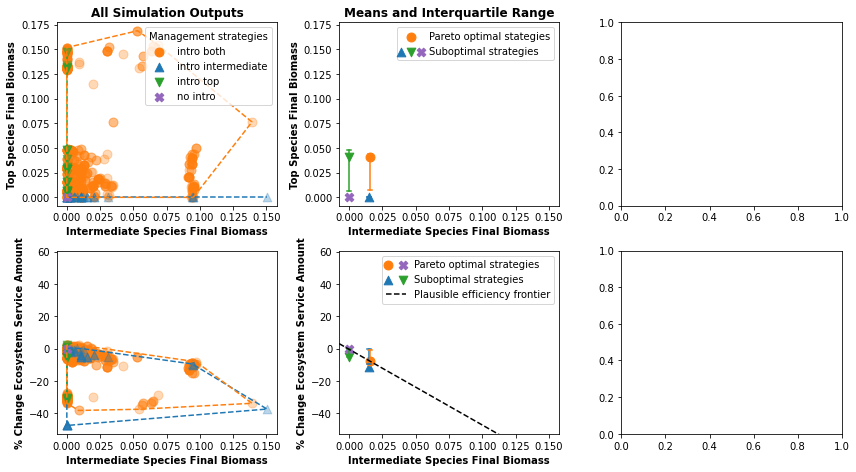

In [87]:
# Trade-off plots, partial, means (for figure of how they are constructed -- Figure 4)
rows_to_plot = [0,1]
medians = False
i_to_show = 0
trade_off_plotting_code(rows_to_plot,i_to_show,medians,False,"Fig_4")

In [88]:
def overall_version(medians,web_index,max_rw,file_name):
    combo_it = combinations(range(0,4),2)
    #combo_it = combinations([0,1,3,4],2) # try with the other ES metric real quick
    index_combos = []
    for c in combo_it:
        index_combos.append(c)
    fig, axes = plt.subplots(max_rw, 2, figsize=(8,20/6*max_rw))
    oc = 0
    axes_order = [0,3,1,4,2,5]
    show = True
    rw_ct = 0 
    for combo in index_combos:
        
        if rw_ct < max_rw:

            to_l = False
            draw_all_webs_plot(web_index,combo[0],combo[1],colors,symbols,sizes,label_strs[combo[0]],label_strs[combo[1]],False,show,axes.flat[oc],to_l,True,medians,False)
            oc+=1

            draw_all_webs_bar_plot(combo[0],combo[1],colors,axes.flat[oc],medians)
            oc+=1

            show = False
        
        rw_ct +=1

    fig.tight_layout()
    
    
    if file_name:

        plt.savefig('./paper_plots/' + file_name + '.png',dpi=1200)
        plt.show()
        plt.close()

    else:
        plt.show()
    

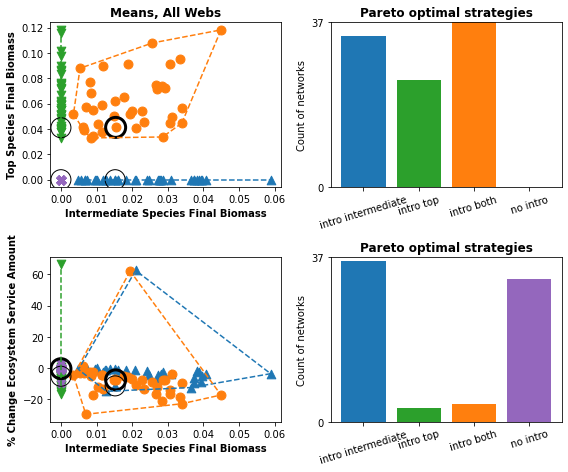

In [89]:
# overall version on plots with axis limits not determined by a particular web - MEANS w/ circle - For Figure 4 
overall_version(False,0,2,"Fig_4_b")

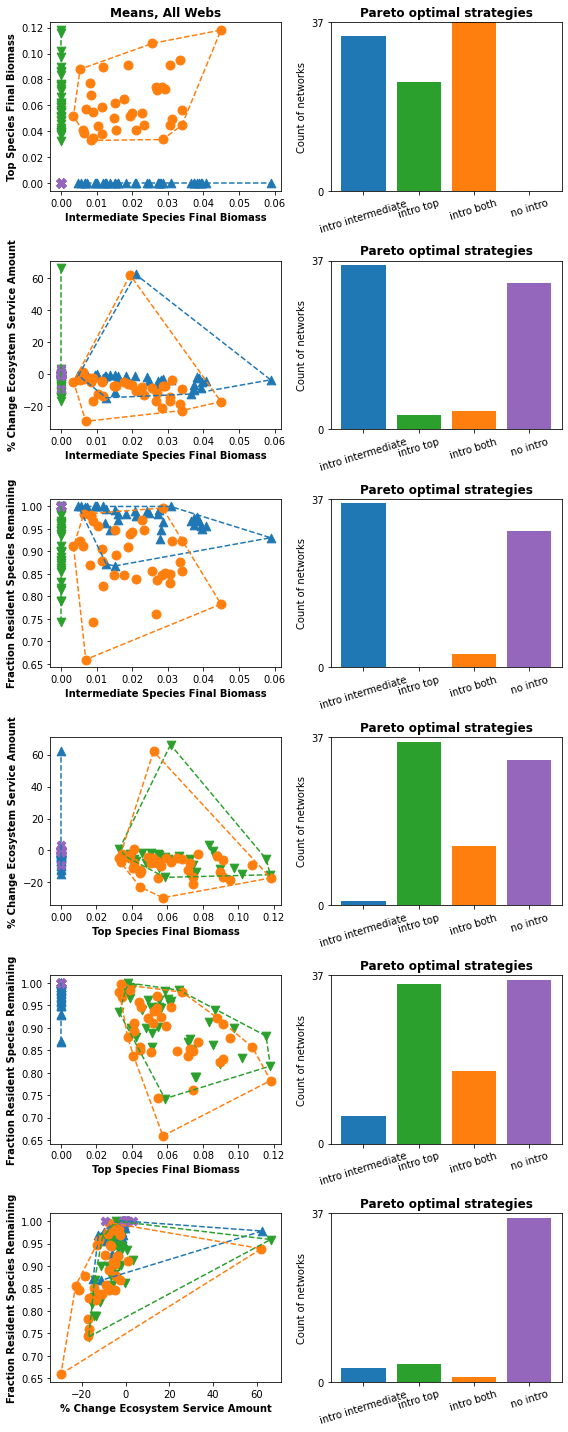

In [90]:
# overall version on plots with axis limits not determined by a particular web - MEANS w/o circle - Figure 6
overall_version(False,-1,6, "Fig_6")

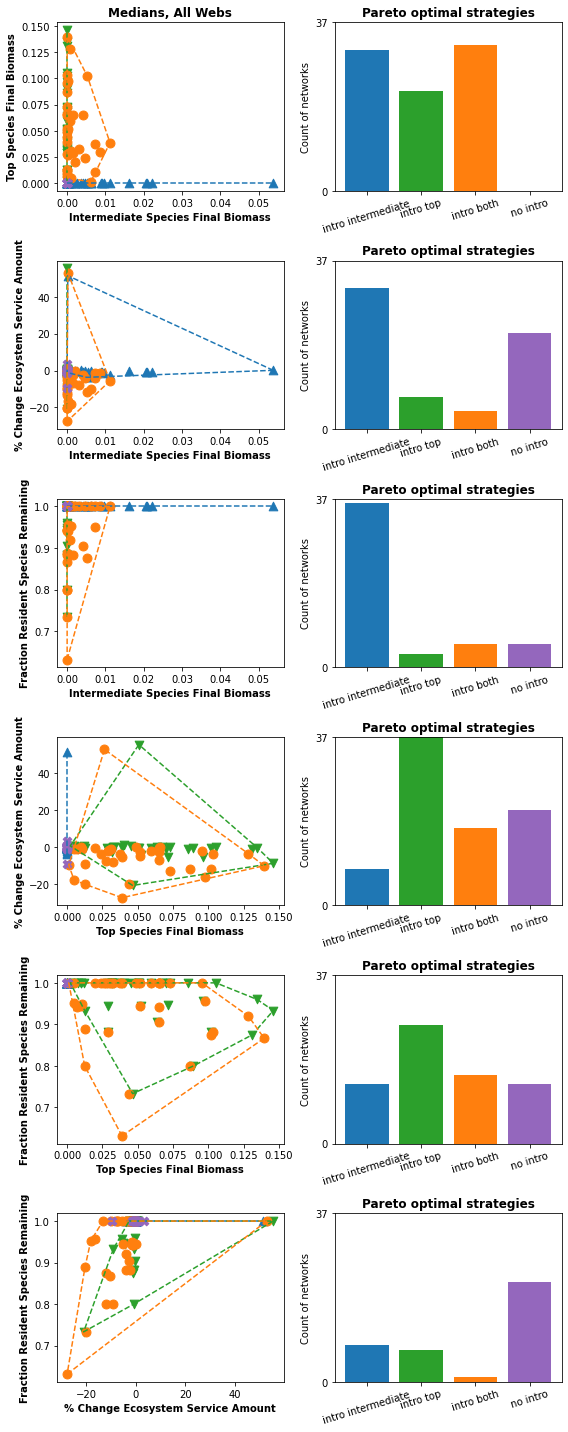

In [91]:
# overall version on plots with axis limits not determined by a particular web - MEDIANS w/o circle - SI Figure 2
overall_version(True, -1, 6, "SI_Fig_2")

In [92]:
# Plotting for maxi-min decision making

# PLOTTING CODE

def plot_maxi_min(rows_to_plot,i_to_show,file_name):
    fif_webs_file = open('./' + results_folder + '/over15_webs.txt','r')
    lowerz = [5]

    ct = 0
    for row in fif_webs_file:

        i = int(row)

        if i == i_to_show:

            combo_it = combinations(range(0,4),2)
            index_combos = []
            for c in combo_it:
                index_combos.append(c)
            fig, axes = plt.subplots(len(rows_to_plot), 3, figsize=(12,20/6*len(rows_to_plot)))
            oc = 0
            show = True
            show_title = True
            rowc = 0
            for combo in index_combos:

                if rowc in rows_to_plot:

                    draw_blobs_plot(ct,combo[0],combo[1],colors,symbols,sizes,label_strs[combo[0]],label_strs[combo[1]],show,show_title,axes.flat[oc])
                    oc +=1

                    draw_worse_case_plot(ct,combo[0],combo[1],colors,symbols,sizes,label_strs[combo[0]],label_strs[combo[1]],True,show_title,axes.flat[oc])
                    oc +=1

                    if rowc in lowerz:
                        to_l = True
                    else:
                        to_l = False
                    draw_all_worst_plot(ct,combo[0],combo[1],colors,symbols,sizes,label_strs[combo[0]],label_strs[combo[1]],False,show_title,axes.flat[oc],to_l,False,True)

                    oc +=1
                    show = False
                    show_title = False

                rowc += 1

            fig.tight_layout()
            
            if file_name:

                plt.savefig('./paper_plots/' + file_name + '.png')
                plt.show()
                plt.close()

            else:
                plt.show()


        ct += 1

    fif_webs_file.close()


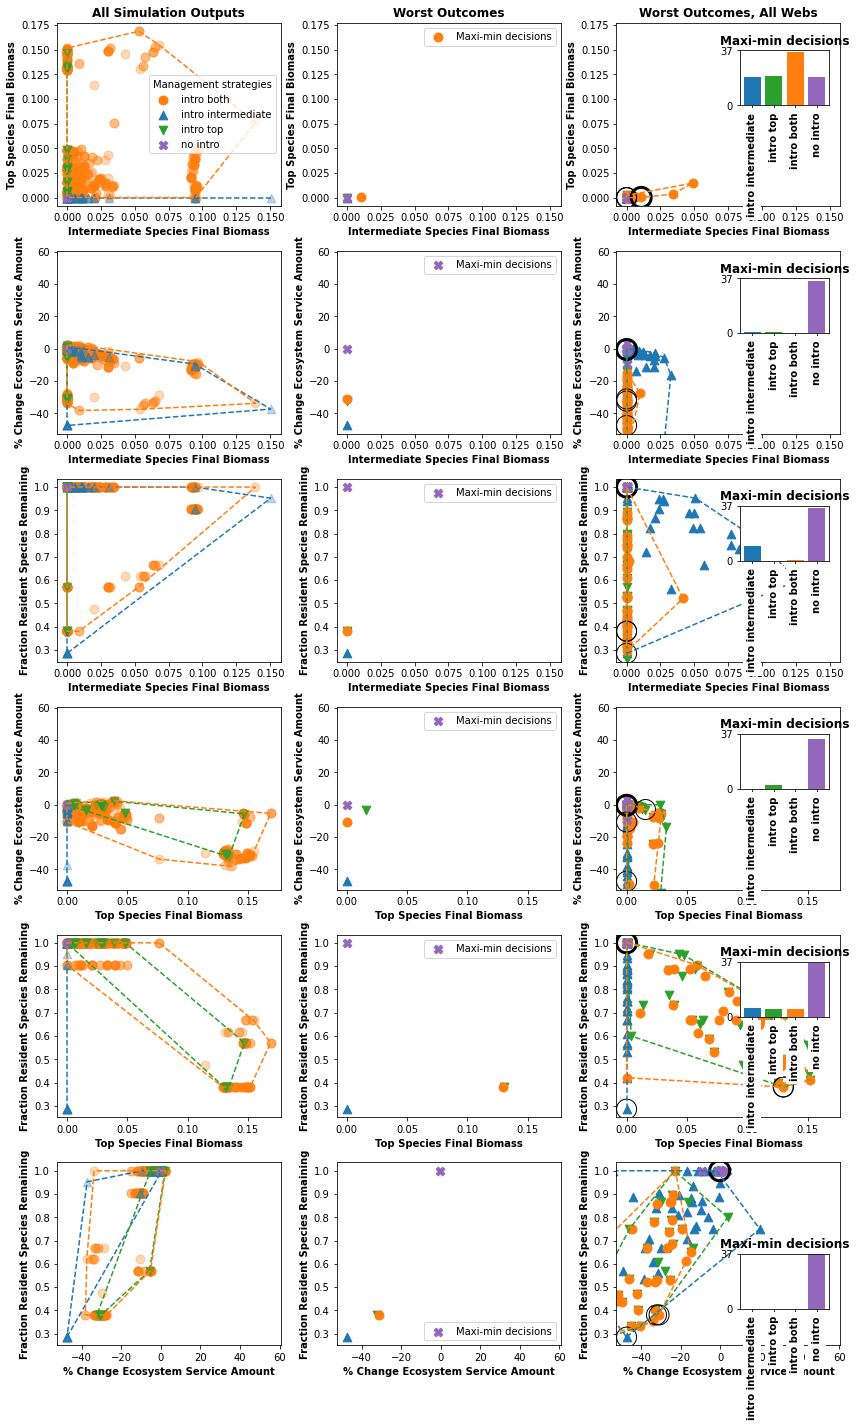

In [95]:
# Full worse case plots - SI Figure 7
rows_to_plot = range(0,6)
i_to_show = 0
plot_maxi_min(rows_to_plot,i_to_show,"SI_Fig_7")

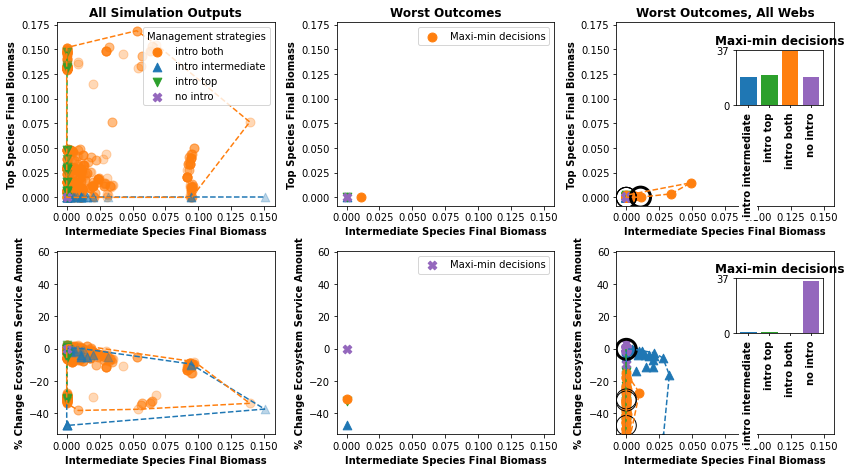

In [93]:
# For showing how worse case plots were constructed -- SI Figure 1
rows_to_plot = [0,1]
i_to_show = 0
plot_maxi_min(rows_to_plot,i_to_show,False)

In [94]:
def worst_overall_version(index_to_show):
    #combo_it = combinations(range(0,4),2)
    combo_it = combinations([0,1,3,4],2) # try with the other ES metric real quick
    index_combos = []
    for c in combo_it:
        index_combos.append(c)
    fig, axes = plt.subplots(6, 2, figsize=(8,20/6*6))
    oc = 0
    axes_order = [0,3,1,4,2,5]
    show = True
    to_l = False
    for combo in index_combos:
        draw_all_worst_plot(index_to_show,combo[0],combo[1],colors,symbols,sizes,label_strs[combo[0]],label_strs[combo[1]],False,show,axes.flat[oc],to_l,True,False)
        oc+=1
        show = False
        
        draw_all_worst_bar_plot(index_to_show,combo[0],combo[1],colors,symbols,sizes,label_strs[combo[0]],label_strs[combo[1]],False,show,axes.flat[oc],to_l,True,False)
        oc+=1
        
    fig.tight_layout()
    plt.show()

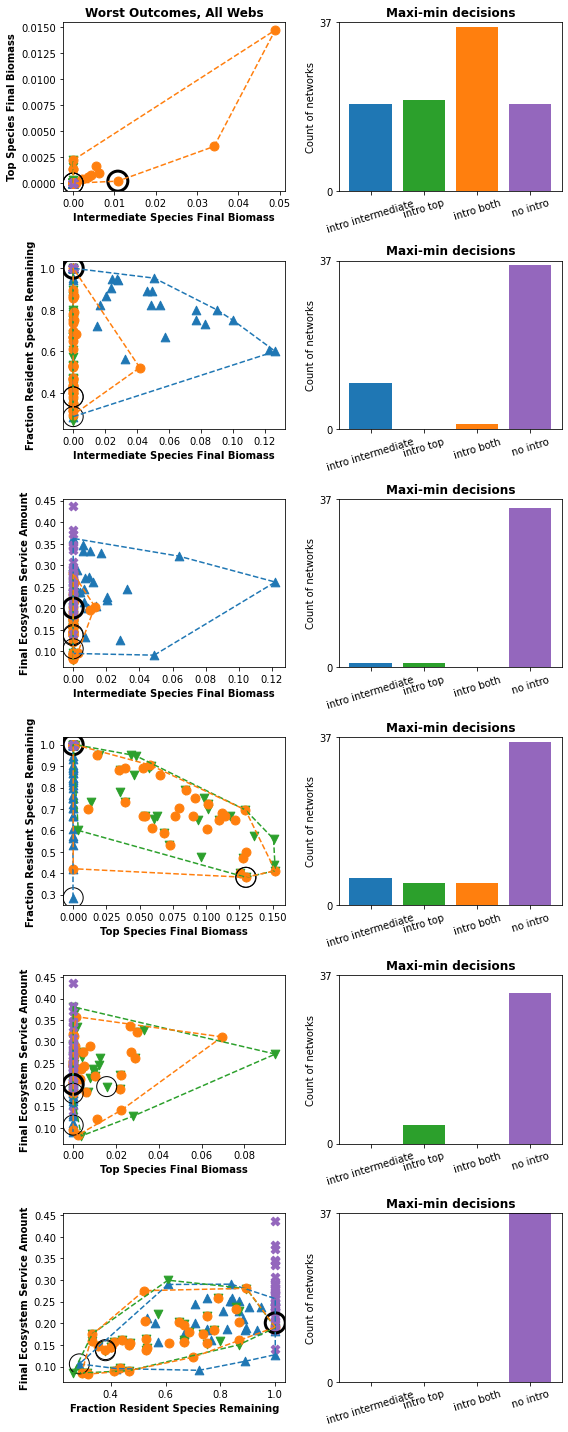

In [96]:
# VERSION FOR SHOWING HOW THEY ARE CONSTRUCTED - SI FIGURE 1
worst_overall_version(0)

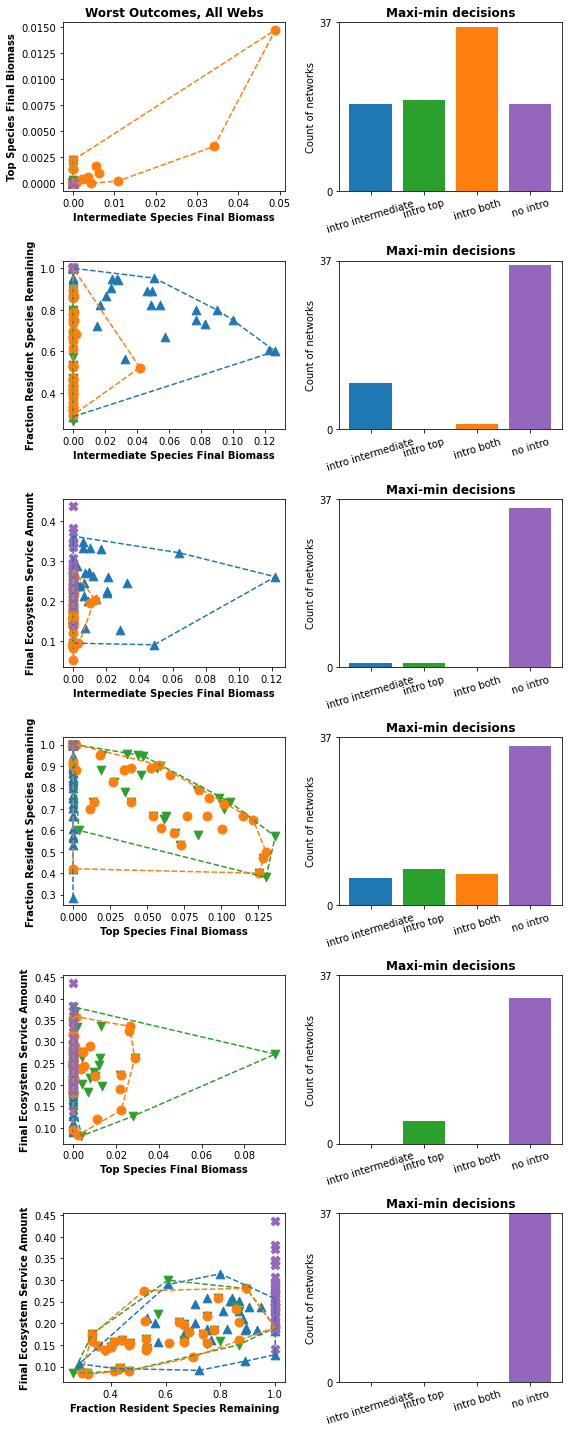

In [97]:
# VERSION PRINTING ONLY THE OVERALL PLOTS ON AXES THAT AREN'T DETERMINED BY THE PARTICULAR WEB - Figure 7 
worst_overall_version(-1)

In [98]:
# Overall mean and coefficient of variation plots

def get_rsd(vect):
    return abs(np.std(vect)/np.mean(vect))

alt1_means = np.zeros((WEBS,5))
alt2_means = np.zeros((WEBS,5))
alt3_means = np.zeros((WEBS,5))
alt1_meds = np.zeros((WEBS,5))
alt2_meds = np.zeros((WEBS,5))
alt3_meds = np.zeros((WEBS,5))
alt1_rsd = np.zeros((WEBS,5))
alt2_rsd = np.zeros((WEBS,5))
alt3_rsd = np.zeros((WEBS,5))

for ct in range(0,WEBS):
    
    alt1_means[ct][:] = np.mean(alt1_mets[ct][:][:],axis=1)
    alt2_means[ct][:] = np.mean(alt2_mets[ct][:][:],axis=1)
    alt3_means[ct][:] = np.mean(alt3_mets[ct][:][:],axis=1)
    
    alt1_meds[ct][:] = np.median(alt1_mets[ct][:][:],axis=1)
    alt2_meds[ct][:] = np.median(alt2_mets[ct][:][:],axis=1)
    alt3_meds[ct][:] = np.median(alt3_mets[ct][:][:],axis=1)
    
    alt1_rsd[ct][:] = abs(np.std(alt1_mets[ct][:][:],axis=1)/np.mean(alt1_mets[ct][:][:],axis=1))
    alt2_rsd[ct][:] = abs(np.std(alt2_mets[ct][:][:],axis=1)/np.mean(alt2_mets[ct][:][:],axis=1))
    alt3_rsd[ct][:] = abs(np.std(alt3_mets[ct][:][:],axis=1)/np.mean(alt3_mets[ct][:][:],axis=1))

/Users/luva6824/jhub_venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/luva6824/jhub_venv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [99]:
# ES results based on a single basal species

def read_es_res(file_name):
    out_obj = []
    alt = open(file_name)
    altr = csv.reader(alt)
    next(altr)
    for rw in altr:
        out_obj.append(float(rw[2]))
    return out_obj
    alt.close()

ct_alles =  read_es_res('./' + results_folder + '/all_es_res_ct.csv')
alt1_alles_mean = read_es_res('./' + results_folder + '/all_es_res_inv1_mean.csv')
alt2_alles_mean = read_es_res('./' + results_folder + '/all_es_res_inv2_mean.csv')
alt3_alles_mean = read_es_res('./' + results_folder + '/all_es_res_invb_mean.csv')
alt1_alles_med = read_es_res('./' + results_folder + '/all_es_res_inv1_median.csv')
alt2_alles_med = read_es_res('./' + results_folder + '/all_es_res_inv2_median.csv')
alt3_alles_med = read_es_res('./' + results_folder + '/all_es_res_invb_median.csv')
alt1_alles_rsd = read_es_res('./' + results_folder + '/all_es_res_inv1_rsd_raw.csv')
alt2_alles_rsd = read_es_res('./' + results_folder + '/all_es_res_inv2_rsd_raw.csv')
alt3_alles_rsd = read_es_res('./' + results_folder + '/all_es_res_invb_rsd_raw.csv')

In [100]:
# Combination plotting code

def remove_indices(initarr,indxs):
    new_arr = np.zeros(len(initarr)-len(indxs))
    ct = 0 
    for i in range(0,len(initarr)):
        if i not in indxs:
            new_arr[ct] = initarr[i]
            ct+=1
    return new_arr
            
def combo_plot(alt1,alt2,alt3,alt_ct,tstr,file_name,remove_out,one_basal_obj):

    fig, axes = plt.subplots(1, 4, figsize=(16,4))

    meanpointprops = dict(markerfacecolor='k',markeredgecolor='k')
    # Species 1 metric
    intro_1s = [alt1[:,0],alt2[:,0],alt3[:,0],alt_ct[:,0]]
    bp1 = axes.flat[0].boxplot(intro_1s,positions=np.array(np.arange(len(intro_1s)))*2.0-0.35,patch_artist=True,
                      showmeans=True,meanprops=meanpointprops)
    # Species 2 metric
    intro_2s = [alt1[:,1],alt2[:,1],alt3[:,1],alt_ct[:,1]]
    bp2 = axes.flat[0].boxplot(intro_2s,positions=np.array(np.arange(len(intro_2s)))*2.0+0.35,patch_artist=True,
                      showmeans=True,meanprops=meanpointprops)

    ticks = mang_labels
    axes.flat[0].set_xticks(np.arange(0, len(ticks) * 2, 2))
    axes.flat[0].set_xticklabels(ticks,rotation=17)
    axes.flat[0].set_ylabel(tstr + " Value",fontweight='bold',fontsize=13)
    axes.flat[0].set_title("Introduced species final biomass")

    for patch in bp1['boxes']:
        patch.set_facecolor(metric_colors[0])
    plt.setp(bp1['medians'], color='k')
    plt.setp(bp1['means'], color='k')
    for patch in bp2['boxes']:
        patch.set_facecolor(metric_colors[1])
    plt.setp(bp2['medians'], color='k')
    plt.setp(bp2['means'], color='k')
    axes.flat[0].set_title("Introduced Species Final Biomass")
    new_lab1 = label_strs[0].replace(" Final Biomass","")
    new_lab2 = label_strs[1].replace(" Final Biomass","")
    axes.flat[0].legend([bp1["boxes"][0], bp2["boxes"][0]],[new_lab1,new_lab2], loc='upper left')


    m = 3
    mns = [alt1[:,m],alt2[:,m],alt3[:,m],alt_ct[:,m]]
    bp4 = axes.flat[1].boxplot(mns,positions=np.array(np.arange(len(mns)))*2.0, patch_artist=True,
                      showmeans=True,meanprops=meanpointprops)
    ticks = mang_labels
    axes.flat[1].set_xticks(np.arange(0, len(ticks) * 2, 2))
    axes.flat[1].set_xticklabels(ticks,rotation=17)
    for patch in bp4['boxes']:
        patch.set_facecolor(metric_colors[m])
    plt.setp(bp4['medians'], color='k')
    plt.setp(bp4['means'], color='k')
    axes.flat[1].set_ylim([0,1])
    axes.flat[1].set_xlabel("Management Alternatives",fontweight='bold',fontsize=13)
    axes.flat[1].set_title(label_strs[m])
    
    m = 2
    #m = 4 # just trying this
    # Fraction es amount remaining
    mns = [alt1[:,m],alt2[:,m],alt3[:,m],alt_ct[:,m]]
    
    print("Outliers for Mean % Change in ES Amount:")
    print("Inv intermediate:")
    out_indxs = []
    for j in range(0,WEBS):
        if alt1[j,m] > 20:
            print("web "+ str(web_map[j+1]) + " " + str(alt1[j,m]))
            if j not in out_indxs:
                out_indxs.append(j)
    print("Inv top:")
    for j in range(0,WEBS):
        if alt2[j,m] > 20:
            print("web " +str(web_map[j+1]) + " " + str(alt2[j,m]))
            if j not in out_indxs:
                out_indxs.append(j)
    print("Inv both:")
    for j in range(0,WEBS):
        if alt3[j,m] > 20:
            print("web " + str(web_map[j+1]) + " " + str(alt3[j,m]))
            if j not in out_indxs:
                out_indxs.append(j)
                
    print("out_indxs: " + str(out_indxs))
    if remove_out:
        mns = [remove_indices(alt1[:,m],out_indxs),remove_indices(alt2[:,m],out_indxs),remove_indices(alt3[:,m],out_indxs),remove_indices(alt_ct[:,m],out_indxs)]
    
    bp4 = axes.flat[2].boxplot(mns,positions=np.array(np.arange(len(mns)))*2.0, patch_artist=True,
                      showmeans=True,meanprops=meanpointprops)
    ticks = mang_labels
    axes.flat[2].set_xticks(np.arange(0, len(ticks) * 2, 2))
    axes.flat[2].set_xticklabels(ticks,rotation=17)
    for patch in bp4['boxes']:
        patch.set_facecolor(metric_colors[m])
    plt.setp(bp4['medians'], color='k')
    plt.setp(bp4['means'], color='k')
    axes.flat[2].axhline(y=0)
    axes.flat[2].set_title(label_strs[m] + "\nAll Basal Species")

    mns = one_basal_obj
    bp4 = axes.flat[3].boxplot(mns,positions=np.array(np.arange(len(mns)))*2.0, patch_artist=True,
                      showmeans=True,meanprops=meanpointprops)
    ticks = mang_labels
    axes.flat[3].set_xticks(np.arange(0, len(ticks) * 2, 2))
    axes.flat[3].set_xticklabels(ticks,rotation=17)
    for patch in bp4['boxes']:
        patch.set_facecolor(metric_colors[m])
    plt.setp(bp4['medians'], color='k')
    plt.setp(bp4['means'], color='k')
    axes.flat[3].axhline(y=0)
    axes.flat[3].set_title(label_strs[m] + "\nOne Basal Species")
    
    plt.tight_layout()
    if file_name:
        plt.savefig('./paper_plots/' + file_name + '.png',dpi=600)
    plt.show()
    plt.close()

Outliers for Mean % Change in ES Amount:
Inv intermediate:
web 47 62.44978061252012
Inv top:
web 47 66.24497579976624
Inv both:
web 47 62.02406095615231
out_indxs: [19]


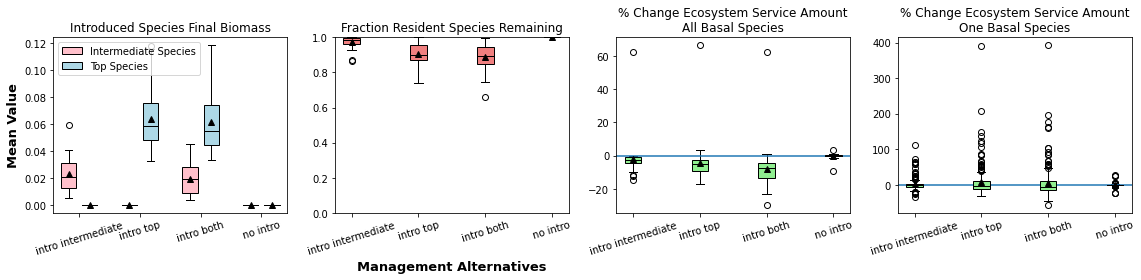

In [101]:
# Combo mean plot - Figure 5
obo = [alt1_alles_mean,alt2_alles_mean,alt3_alles_mean,ct_alles]
combo_plot(alt1_means,alt2_means,alt3_means,ct_mets,"Mean","Fig_5",False,obo)

Outliers for Mean % Change in ES Amount:
Inv intermediate:
web 47 62.44978061252012
Inv top:
web 47 66.24497579976624
Inv both:
web 47 62.02406095615231
out_indxs: [19]


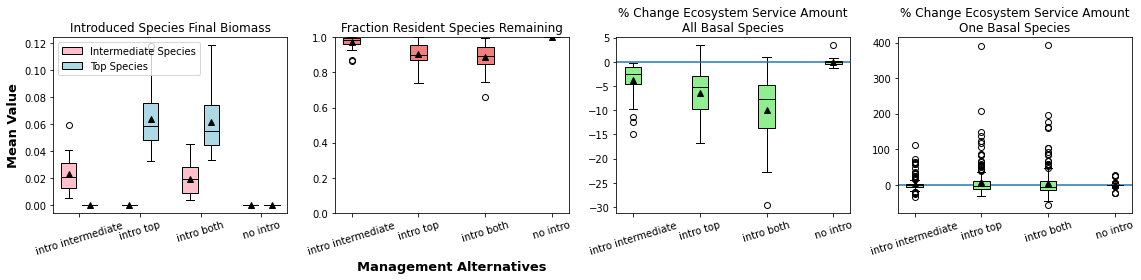

In [102]:
# Combo mean plot - Figure 5 (removing outliers) -- 
obo = [alt1_alles_mean,alt2_alles_mean,alt3_alles_mean,ct_alles]
combo_plot(alt1_means,alt2_means,alt3_means,ct_mets,"Mean","Fig_5",True,obo)

Outliers for Mean % Change in ES Amount:
Inv intermediate:
web 47 51.456789712768305
Inv top:
web 47 55.48337874960888
Inv both:
web 47 52.8739275836858
out_indxs: [19]


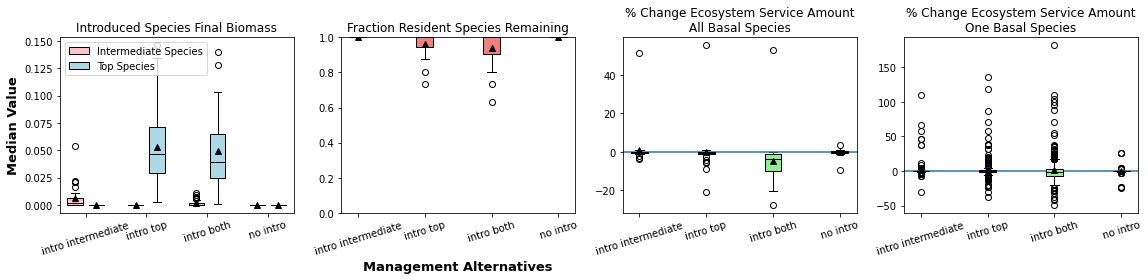

In [103]:
# Combo median plot - SI Figure 8
obo = [alt1_alles_med,alt2_alles_med,alt3_alles_med,ct_alles]
combo_plot(alt1_meds,alt2_meds,alt3_meds,ct_mets,"Median",False,False,obo)

Outliers for Mean % Change in ES Amount:
Inv intermediate:
web 47 51.456789712768305
Inv top:
web 47 55.48337874960888
Inv both:
web 47 52.8739275836858
out_indxs: [19]


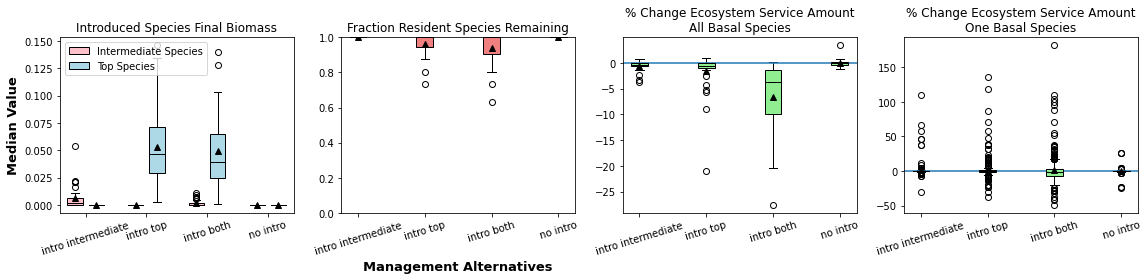

In [104]:
# with outlier removed
obo = [alt1_alles_med,alt2_alles_med,alt3_alles_med,ct_alles]
combo_plot(alt1_meds,alt2_meds,alt3_meds,ct_mets,"Median",False,True,obo)

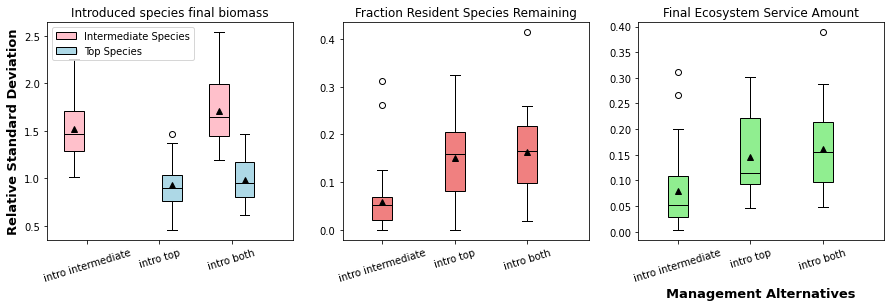

In [105]:
# Relative standard deviation plot

fig, axes = plt.subplots(1, 3, figsize=(15,4))

meanpointprops = dict(markerfacecolor='k',markeredgecolor='k')
# Species 1 metric
alt3_rev = alt3_rsd[:,0][~np.isnan(alt3_rsd[:,0])] # get rid of a nan
intro_1s = [alt1_rsd[:,0],alt2_rsd[:,0],alt3_rev]
bp1 = axes.flat[0].boxplot(intro_1s,positions=np.array(np.arange(len(intro_1s)))*2.0-0.35,patch_artist=True,
                  showmeans=True,meanprops=meanpointprops,widths=(0.55,0.55,0.55))
# Species 2 metric
intro_2s = [alt1_rsd[:,1],alt2_rsd[:,1],alt3_rsd[:,1]]
bp2 = axes.flat[0].boxplot(intro_2s,positions=np.array(np.arange(len(intro_1s)))*2.0+0.35,patch_artist=True,
                  showmeans=True,meanprops=meanpointprops,widths=(0.55,0.55,0.55))
ticks = mang_labels[0:3]
axes.flat[0].set_xticks([0,2,4])
axes.flat[0].set_xticklabels(ticks,rotation=17)
axes.flat[0].set_ylabel("Relative Standard Deviation",fontweight='bold',fontsize=13)
for patch in bp1['boxes']:
    patch.set_facecolor(metric_colors[0])
plt.setp(bp1['medians'], color='k')
plt.setp(bp1['means'], color='k')
for patch in bp2['boxes']:
    patch.set_facecolor(metric_colors[1])
plt.setp(bp2['medians'], color='k')
plt.setp(bp2['means'], color='k')
axes.flat[0].set_title("Introduced species final biomass")
axes.flat[0].set_xlim([-1.1,5.7])
new_lab1 = label_strs[0].replace(" Final Biomass","")
new_lab2 = label_strs[1].replace(" Final Biomass","")
axes.flat[0].legend([bp1["boxes"][0], bp2["boxes"][0]],[new_lab1,new_lab2], loc='upper left')

# BIO PLOT - separate
m = 3
meanpointprops = dict(markerfacecolor='k',markeredgecolor='k')
bios = [alt1_rsd[:,m],alt2_rsd[:,m],alt3_rsd[:,m]]
bp3 = axes.flat[1].boxplot(bios,positions=np.array(np.arange(len(bios)))*2.0, patch_artist=True,
                  showmeans=True,meanprops=meanpointprops,widths=(0.55,0.55,0.55))
ticks = mang_labels[0:3]
axes.flat[1].set_xticks([0,2,4])
axes.flat[1].set_xticklabels(ticks,rotation=17)
for patch in bp3['boxes']:
    patch.set_facecolor(metric_colors[m])
plt.setp(bp3['medians'], color='k')
plt.setp(bp3['means'], color='k')
axes.flat[1].set_xlim([-1.1,5.7])
axes.flat[1].set_title(label_strs[m])

# ES PLOT - separate
m = 4 # Base this off of the raw final ES amount 
meanpointprops = dict(markerfacecolor='k',markeredgecolor='k')
ess = [alt1_rsd[:,m],alt2_rsd[:,m],alt3_rsd[:,m]]
bp3 = axes.flat[2].boxplot(ess,positions=np.array(np.arange(len(ess)))*2.0, patch_artist=True,
                  showmeans=True,meanprops=meanpointprops,widths=(0.55,0.55,0.55))
ticks = mang_labels[0:3]
axes.flat[2].set_xticks([0,2,4])
axes.flat[2].set_xticklabels(ticks,rotation=17)
for patch in bp3['boxes']:
    patch.set_facecolor(metric_colors[m])
plt.setp(bp3['medians'], color='k')
plt.setp(bp3['means'], color='k')
axes.flat[2].set_xlabel("Management Alternatives",fontweight='bold',fontsize=13)
axes.flat[2].set_xlim([-1.1,5.7])
#axes.flat[1].set_ylim([0,20])
axes.flat[2].set_title(label_strs[m])

# if not os.path.exists('./overall_plots_0421'):
#     os.mkdir('./overall_plots_0421')

# plt.savefig('./overall_plots_0421/relative_sd.png')

plt.show()

In [39]:
# Identify a web for which the % change es amount was positive (based on Means)

# Introduce 1
wi = 1
print("intro 1: ")
for val in alt1_means[:,2]:
    if (val > 0):
        print("web " + str(web_map[wi]) + ", " + str(val))
    wi +=1

# Introduce 2
wi = 1
print("intro 2: ")
for val in alt2_means[:,2]:
    if (val > 0):
        print("web " + str(web_map[wi])+ ", " + str(val))
    wi +=1

# Introduce both
wi = 1
print("intro both: ")
for val in alt3_means[:,2]:
    if (val > 0):
        print("web " + str(web_map[wi])+ ", " + str(val))
    wi +=1

# counterfactual
wi = 1
print("intro none: ")
for val in ct_mets[:,2]:
    if (val > 0):
        print("web " + str(web_map[wi])+ ", " + str(val))
    wi +=1


intro 1: 
web 47, 62.44978061252012
intro 2: 
web 28, 0.707279367334691
web 47, 66.24497579976624
web 76, 3.40088684455111
intro both: 
web 28, 1.002414441785057
web 47, 62.02406095615231
intro none: 
web 8, 0.16224452285091062
web 10, 0.24468207089278599
web 13, 0.8010503588676421
web 14, 0.5968904174900997
web 19, 0.1754263699835612
web 24, 0.15996601365837287
web 25, 0.42852070960536737
web 28, 0.5230266992334065
web 36, 0.35146664761095636
web 41, 0.20997309508557094
web 49, 0.4515816203435683
web 50, 0.31326580662375525
web 55, 0.2077131963810876
web 74, 0.25777058856765384
web 75, 3.408855767834832
web 76, 0.6485921538383653
web 99, 0.20588704445039982


In [40]:
# SI Figure - ES increase after introduction more than in counterfactual case when ES provided by one basal species

# Find case
alt2_f = open('./' + results_folder + '/all_es_res_inv2.csv')
ca_temp = {}
ca_f = open('./' + results_folder + '/counterfactual_results_newmet.csv')
ca_fr = csv.reader(ca_f)
next(ca_fr)
for car in ca_fr:
    ca_temp[car[0]] = car[3] 
ca_f.close()
alt2_r = csv.reader(alt2_f)
next(alt2_r)
for rw in alt2_r:
    if float(rw[2]) > 0:
        #counterfactual amount
        ca = ca_temp[rw[0]]
        if rw[2] > ca:
            print("web: " + str(rw[0]) + " es node id: " + str(rw[1]) + " mean amount: " + str(rw[2]) + " without inv: " + str(ca))
alt2_f.close()

web: 0 es node id: 10 mean amount: 11.387711615653183 without inv: -0.3999448280360142
web: 0 es node id: 19 mean amount: 8.245633378191895 without inv: -0.3999448280360142
web: 4 es node id: 1 mean amount: 20.708905570021297 without inv: -0.46988590362508215
web: 4 es node id: 17 mean amount: 8.421600933825584 without inv: -0.46988590362508215
web: 4 es node id: 21 mean amount: 83.57200532674867 without inv: -0.46988590362508215
web: 8 es node id: 12 mean amount: 21.50969642821347 without inv: 0.16224452285091062
web: 10 es node id: 22 mean amount: 3.3507270607204425 without inv: 0.24468207089278599
web: 13 es node id: 2 mean amount: 1.0694758973943435 without inv: 0.8010503588676421
web: 14 es node id: 2 mean amount: 12.280681060143975 without inv: 0.5968904174900997
web: 14 es node id: 13 mean amount: 15.027290641442082 without inv: 0.5968904174900997
web: 16 es node id: 6 mean amount: 12.15341177775129 without inv: -0.6753116071980839
web: 18 es node id: 19 mean amount: 1.989735387

In [108]:
# Chose a random one... 
# web: 55 es node id: 1 amount: 93.63366678970164 without inv: 0.2077131963810876
es_id = 1

# choose specific invader
inv2 = open('./' + results_folder + '/invader_2.csv')
inv2r = csv.reader(inv2)
next(inv2r)
web_55,_,_,_,b_55 = niche.read_web_from_file("./" + results_folder + "/web_55_2000")
es_amt_before = b_55[es_id]*0.5
web_55,_,_,_,b_55 = niche.read_web_from_file("./" + results_folder + "/web_55_2000_2000")
es_amt_after = b_55[es_id]*0.5
cfc = (es_amt_after-es_amt_before)/es_amt_before*100
for row in inv2r:
    inv2_id=row[0]
    web_55,_,_,_,b_55 = niche.read_web_from_file("./" + results_folder + "/web_55_inv/two/web_55_inv_" +str(inv2_id))
    es_amt_before = b_55[es_id]*0.5
    web_55,_,_,_,b_55 = niche.read_web_from_file("./" + results_folder + "/web_55_inv/two/web_55_inv_" + str(inv2_id) + "_2000")
    es_amt_after = b_55[es_id]*0.5
    invc = (es_amt_after-es_amt_before)/es_amt_before*100
    print("inv id: " + str(inv2_id) + " percent change counterfactual: " + str(cfc) + " percent change invaded: " + str(invc))
inv2.close()

inv id: 334 percent change counterfactual: 0.35816739142234205 percent change invaded: 289.8366892951598
inv id: 336 percent change counterfactual: 0.35816739142234205 percent change invaded: -1.3314503679060352e-14
inv id: 338 percent change counterfactual: 0.35816739142234205 percent change invaded: -0.2396675987869689
inv id: 340 percent change counterfactual: 0.35816739142234205 percent change invaded: 288.6314854340564
inv id: 342 percent change counterfactual: 0.35816739142234205 percent change invaded: -0.1515932154305789
inv id: 344 percent change counterfactual: 0.35816739142234205 percent change invaded: 217.2094299118511
inv id: 346 percent change counterfactual: 0.35816739142234205 percent change invaded: -45.63114511426364
inv id: 348 percent change counterfactual: 0.35816739142234205 percent change invaded: -0.2442849265041509
inv id: 350 percent change counterfactual: 0.35816739142234205 percent change invaded: 217.2094299118511
inv id: 352 percent change counterfactual:

COUNTERFACTUAL


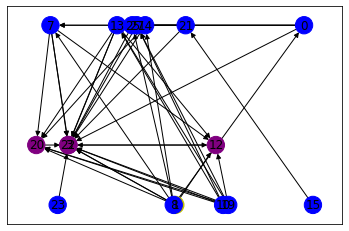

without the fix!
running dynamics for -- ./paper_webs_0624/web_55_2000 2000 timesteps...
index dict: 
{0: 0, 1: 1, 3: 2, 7: 3, 8: 4, 10: 5, 12: 6, 13: 7, 14: 8, 15: 9, 19: 10, 20: 11, 21: 12, 22: 13, 23: 14, 25: 15, 27: 16}


/Users/luva6824/species_intro_modelling/ATN.py:68: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:48: RuntimeWarning: invalid value encountered in double_scalars
  b_sum += (b_curr[index_dict[k]]**(1+q))
/Users/luva6824/species_intro_modelling/ATN.py:50: RuntimeWarning: invalid value encountered in double_scalars
  Fij = (b_curr[index_dict[j]]**(1+q))/(b_sum + (b0**(1+q)))
/Users/luva6824/species_intro_modelling/ATN.py:69: RuntimeWarning: invalid value encountered in double_scalars
  Fji = (b_curr[index_dict[i]]**(1+q))/(b_sum + (b0**(1+q)))


overall:


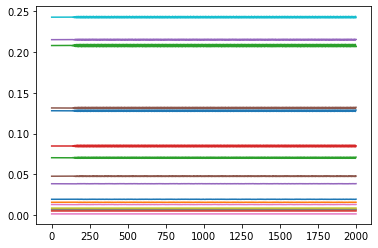

group 1:
group 2:
group 3:


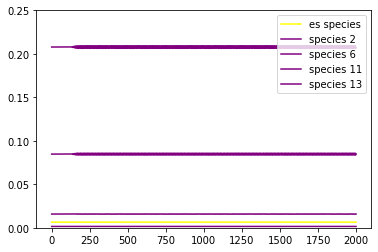

./paper_webs_0624/web_55_2000 final nodes: 17
final number of species after 2000 timesteps: 17
time for ./paper_webs_0624/web_55_2000 12.642178297042847
es amount before: 0.003257206422769249es amount after: 0.003268872674046923
percent change: 0.35816739142234205
INVASION


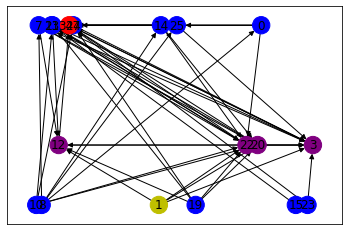

without the fix!
running dynamics for -- ./paper_webs_0624/web_55_inv/two/web_55_inv_344 2000 timesteps...
index dict: 
{0: 0, 1: 1, 3: 2, 7: 3, 8: 4, 10: 5, 12: 6, 13: 7, 14: 8, 15: 9, 19: 10, 20: 11, 21: 12, 22: 13, 23: 14, 25: 15, 27: 16, 344: 17}
overall:


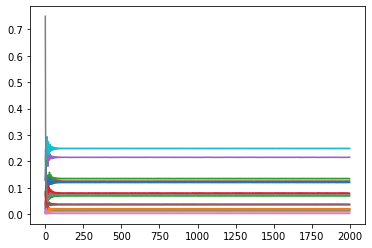

group 1:
group 2:
group 3:


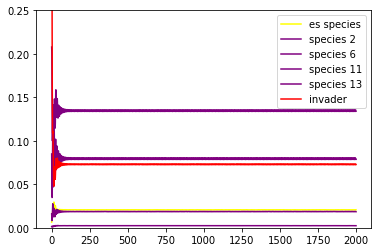

./paper_webs_0624/web_55_inv/two/web_55_inv_344 final nodes: 18
final number of species after 2000 timesteps: 18
time for ./paper_webs_0624/web_55_inv/two/web_55_inv_344 15.693527221679688
es amount before: 0.003257206422769249es amount after: 0.010332165924718533
percent change: 217.2094299118511


In [2]:
inv2_id = 344
es_id = 1

# Before introduction

#Run and plot simulation - counterfactual
print("COUNTERFACTUAL")
web_55,_,_,_,b_55 = niche.read_web_from_file("./" + results_folder + "/web_55_2000")
es_amt_before = b_55[es_id]*0.5

#find the ones that interact with the es
out_neighs = []
out_neigh_list = list(web_55.out_edges([es_id]))
for out_neigh in out_neigh_list:
    out_neighs.append(out_neigh[1])
int_ids = out_neighs
in_neighs = []
in_neigh_list = list(web_55.in_edges([es_id]))
for in_neigh in in_neigh_list: #curr_web.in_degree(node):
    in_neighs.append(in_neigh[0])
assert len(in_neighs) == 0

atn_args = ["./" + results_folder + "/web_55_2000",2000,True,[],int_ids,[es_id]]
niche.viz_web_inv_es_int(web_55,[],[es_id],int_ids)
ATN.run_dynamics(atn_args)
web_55,_,_,_,b_55 = niche.read_web_from_file("./" + results_folder + "/web_55_2000_2000")
es_amt_after = b_55[es_id]*0.5
print("es amount before: " + str(es_amt_before) + "es amount after: " + str(es_amt_after))
print("percent change: " + str((es_amt_after-es_amt_before)/es_amt_before*100))

#Run and plot simulation - with invasion
print("INVASION")
web_55,_,_,_,b_55 = niche.read_web_from_file("./" + results_folder + "/web_55_inv/two/web_55_inv_" +str(inv2_id))
es_amt_before = b_55[es_id]*0.5
#find the ones that interact with the es and invader
out_neighs = []
out_neigh_list = list(web_55.out_edges([es_id]))
for out_neigh in out_neigh_list:
    out_neighs.append(out_neigh[1])
#int_ids = out_neighs
in_neighs = []
in_neigh_list = list(web_55.in_edges([inv2_id]))
for in_neigh in in_neigh_list:
    in_neighs.append(in_neigh[0])
# get the nodes between the two 
int_ids = [value for value in out_neighs if value in in_neighs]  
#int_ids = int_ids + in_neighs

atn_args = ["./" + results_folder + "/web_55_inv/two/web_55_inv_"+str(inv2_id),2000,True,[inv2_id],int_ids,[es_id]]
niche.viz_web_inv_es_int(web_55,[inv2_id],[es_id],int_ids)
ATN.run_dynamics(atn_args)
web_55,_,_,_,b_55 = niche.read_web_from_file("./" + results_folder + "/web_55_inv/two/web_55_inv_" + str(inv2_id) + "_2000")
es_amt_after = b_55[es_id]*0.5
print("es amount before: " + str(es_amt_before) + "es amount after: " + str(es_amt_after))
print("percent change: " + str((es_amt_after-es_amt_before)/es_amt_before*100))